## Quantitative Analysis: Bitcoin Price Prediction
5/28/2023
<br>Lidong (Aaron) Yang
<br>Jiadi Zhang

### Data Preparation

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas_ta as ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer,StandardScaler
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.model_selection import GridSearchCV  

In [2]:
df_price = pd.read_csv('data/bitcoin-price-usd.csv')
df_price

timestamp         value
0       2010-07-17T23:00:00Z      0.049510
1       2010-07-18T00:00:00Z      0.049510
2       2010-07-18T01:00:00Z      0.049510
3       2010-07-18T02:00:00Z      0.049510
4       2010-07-18T03:00:00Z      0.059410
...                      ...           ...
112325  2023-05-11T04:00:00Z  27512.016824
112326  2023-05-11T05:00:00Z  27548.006729
112327  2023-05-11T06:00:00Z  27512.564596
112328  2023-05-11T07:00:00Z  27448.817765
112329  2023-05-11T08:00:00Z  27419.845123

[112330 rows x 2 columns]

In [3]:
# check for missing data
if df_price.isnull().values.any():
    print('Missing data detected')
else:
    print('No missing data detected.')

No missing data detected.


In [4]:
# check if the timestamp is continuous
df_price['timestamp'] = pd.to_datetime(df_price['timestamp'])

df_price['time_diff'] = df_price['timestamp'].diff()
gaps = df_price[df_price['time_diff'] > pd.Timedelta('1 hour')]

if gaps.empty:
    print('No missing hourly data.')
else:
    print('Missing hourly data detected:')
    print(gaps)

No missing hourly data.


In [5]:
# Now I want to see daily open, close, high, and low price
# convert timestamp to datetime
df_price['timestamp'] = pd.to_datetime(df_price['timestamp'])
df_price['date'] = df_price['timestamp'].dt.date

# resample to daily data
df_price_daily = df_price.groupby('date').agg({
    'value': ['first', 'last', 'max', 'min']
})

df_price_daily.columns = ['_'.join(t) for t in df_price_daily.columns]

df_price_daily.rename(columns={
    'value_first': 'open',
    'value_last': 'close',
    'value_max': 'high',
    'value_min': 'low',
}, inplace=True)

# To prevent data leaking, we only observe the previous day's price when we predict BTC
# So, add previous day's open, close, high, and low prices
df_price_daily['prev_open'] = df_price_daily['open'].shift()
df_price_daily['prev_close'] = df_price_daily['close'].shift()
df_price_daily['prev_high'] = df_price_daily['high'].shift()
df_price_daily['prev_low'] = df_price_daily['low'].shift()


# merge daily data back to original dataset
df_price = df_price.merge(df_price_daily, how='left', left_on='date', right_index=True)


In [6]:
# load the additional csv files

df_number_of_addresses = pd.read_csv('data/bitcoin-number-of-addresses-with-balance-100.csv')
df_transfer_volume = pd.read_csv('data/bitcoin-total-transfer-volume-entity-adjusted-btc.csv')


df_number_of_addresses['timestamp'] = pd.to_datetime(df_number_of_addresses['timestamp'])
df_transfer_volume['timestamp'] = pd.to_datetime(df_transfer_volume['timestamp'])


df_number_of_addresses.rename(columns= {'value': 'number_of_addresse',}, inplace=True)
df_transfer_volume.rename(columns= {'value': 'total-transfer-volume',}, inplace=True)

# Same apply here, we only observe the previous hour/day's data when we predict BTC
# So, add previous hour/day's related data
df_number_of_addresses['prev_number_of_addresse'] = df_number_of_addresses['number_of_addresse'].shift()
df_transfer_volume['prev_total-transfer-volume'] = df_transfer_volume['total-transfer-volume'].shift()

# merge these dataframes with the original dataframe
df_price = df_price.merge(df_number_of_addresses, how='left', on='timestamp')
df_price = df_price.merge(df_transfer_volume, how='left', on='timestamp')

In [7]:
df_net_position = pd.read_csv('data/bitcoin-long-term-holder-net-position-change.csv')
df_net_position['timestamp'] = pd.to_datetime(df_net_position['timestamp'])
df_net_position['date'] = df_net_position['timestamp'].dt.date
df_net_position.drop('timestamp', axis=1, inplace=True)
df_net_position.rename(columns= {'value': 'net_position_change',}, inplace=True)
df_net_position['prev_net_position_change'] = df_net_position['net_position_change'].shift()
df_price = df_price.merge(df_net_position, how='left', on='date')

In [8]:
df_supply = pd.read_csv('data/bitcoin-relative-address-supply-distribution.csv')
df_supply['timestamp'] = pd.to_datetime(df_supply['timestamp'])
df_supply['date'] = df_supply['timestamp'].dt.date
df_supply.drop('timestamp', axis=1, inplace=True)

for col in df_supply.columns:
    if col != 'date': 
        df_supply['prev_' + col] = df_supply[col].shift()
df_supply = df_supply.drop(columns=['0001_001', '001_01', '01_1', '100_1k', '10_100', '10k_100k', '1_10', '1k_10k', 'above_100k', 'less_0001'])
df_price = df_price.merge(df_supply, how='left', on='date')

In [9]:
df_price['total-transfer-scale'] = df_price['total-transfer-volume'] * df_price['value']
df_price

timestamp         value       time_diff        date   
0      2010-07-17 23:00:00+00:00      0.049510             NaT  2010-07-17  \
1      2010-07-18 00:00:00+00:00      0.049510 0 days 01:00:00  2010-07-18   
2      2010-07-18 01:00:00+00:00      0.049510 0 days 01:00:00  2010-07-18   
3      2010-07-18 02:00:00+00:00      0.049510 0 days 01:00:00  2010-07-18   
4      2010-07-18 03:00:00+00:00      0.059410 0 days 01:00:00  2010-07-18   
...                          ...           ...             ...         ...   
112325 2023-05-11 04:00:00+00:00  27512.016824 0 days 01:00:00  2023-05-11   
112326 2023-05-11 05:00:00+00:00  27548.006729 0 days 01:00:00  2023-05-11   
112327 2023-05-11 06:00:00+00:00  27512.564596 0 days 01:00:00  2023-05-11   
112328 2023-05-11 07:00:00+00:00  27448.817765 0 days 01:00:00  2023-05-11   
112329 2023-05-11 08:00:00+00:00  27419.845123 0 days 01:00:00  2023-05-11   

                open         close          high           low     prev_open   
0           0.049510      0.049510      0.049510      0.049510           NaN  \
1           0.049510      0.085840      0.085850      0.049510      0.049510   
2           0.049510      0.085840      0.085850      0.049510      0.049510   
3           0.049510      0.085840      0.085850      0.049510      0.049510   
4           0.049510      0.085840      0.085850      0.049510      0.049510   
...              ...           ...           ...           ...           ...   
112325  27546.552065  27419.845123  27586.330507  27419.845123  27749.649572   
112326  27546.552065  27419.845123  27586.330507  27419.845123  27749.649572   
112327  27546.552065  27419.845123  27586.330507  27419.845123  27749.649572   
112328  27546.552065  27419.845123  27586.330507  27419.845123  27749.649572   
112329  27546.552065  27419.845123  27586.330507  27419.845123  27749.649572   

          prev_close  ...  prev_001_01  prev_01_1  prev_100_1k  prev_10_100   
0                NaN  ...     0.000010   0.000008     0.023860     0.714676  \
1           0.049510  ...     0.000011   0.000008     0.024116     0.711999   
2           0.049510  ...     0.000011   0.000008     0.024116     0.711999   
3           0.049510  ...     0.000011   0.000008     0.024116     0.711999   
4           0.049510  ...     0.000011   0.000008     0.024116     0.711999   
...              ...  ...          ...        ...          ...          ...   
112325  27611.858127  ...          NaN        NaN          NaN          NaN   
112326  27611.858127  ...          NaN        NaN          NaN          NaN   
112327  27611.858127  ...          NaN        NaN          NaN          NaN   
112328  27611.858127  ...          NaN        NaN          NaN          NaN   
112329  27611.858127  ...          NaN        NaN          NaN          NaN   

        prev_10k_100k  prev_1_10  prev_1k_10k  prev_above_100k   
0            0.173256   0.002514     0.085677              0.0  \
1            0.172821   0.002498     0.088548              0.0   
2            0.172821   0.002498     0.088548              0.0   
3            0.172821   0.002498     0.088548              0.0   
4            0.172821   0.002498     0.088548              0.0   
...               ...        ...          ...              ...   
112325            NaN        NaN          NaN              NaN   
112326            NaN        NaN          NaN              NaN   
112327            NaN        NaN          NaN              NaN   
112328            NaN        NaN          NaN              NaN   
112329            NaN        NaN          NaN              NaN   

        prev_less_0001  total-transfer-scale  
0                  0.0          9.919328e+00  
1                  0.0          6.011252e+02  
2                  0.0          2.411345e+02  
3                  0.0          3.002881e+01  
4                  0.0          7.494572e+00  
...                ...                   ...  
112325             NaN          9.823168e+07  
112326 

In [10]:
df_price_date = df_price.groupby('date').agg(
    open=('open', 'first'),
    close=('close', 'last'),
    high=('high', 'max'),
    low=('low', 'min')
)

# Create a candlestick plot
candlestick = go.Candlestick(
x = df_price_date.index,
open = df_price_date['open'],
high = df_price_date['high'],
low = df_price_date['low'],
close = df_price_date['close'])

fig = go.Figure(data=[candlestick])

fig.show()

A lot of fluctuation in recent years.

## Feature Engineering
This part is refered to https://medium.com/@rohansawant7978/forecasting-of-bitcoin-price-using-machine-learning-deep-learning-techniques-93bf662f46ab
<br>I consider using the following features:
### Simple Moving Average
* A simple moving average (SMA) calculates the average of a selected range of feature values for a number of periods in that range.

* It determins if an asset price will continue or if it will reverse a bull or bear trend.

### Exponential Moving Average
* The EMA is a moving average that places a greater weight and significance on the most recent data points. They work similar to WMA but formula is different.
![Image](https://www.thebalance.com/thmb/bUl41pugmmQnuoLXScHzSAAla3c=/1648x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/EMA-a566789cf300425c80352fb70a6c0666.jpg)
* The EMA adapts more quickly to price changes than the SMA does. For example, when a price reverses direction, the EMA will reverse direction more quickly than the SMA will, because the EMA formula gives more weight to recent prices and less weight to prices from the past.

### Bollinger Bands
* Bollinger Bands are envelopes (Upper and Lower range levels) plotted at a standard deviation level above and below a simple moving average of the price. Because the distance of the bands is based on standard deviation, they adjust to volatility swings in the underlying price.


```
Upper band: n-day SMA + (n-day standard deviation x2)
Lower band: n-day SMA – (n-day standard deviation x2)

```

* Bollinger bands help determine whether values are high or low on a relative basis. They are used in pairs, both upper and lower bands and in conjunction with a moving average. Further, the pair of bands is not intended to be used on its own. Use the pair to confirm signals given with other indicators.

## Moving Average Convergence Divergence
The MACD represents a trend following indicator that highlights whether the short-term price momentum is moving in the same direction as the long-term price momentum, and in cases where it's not, then it's used to determine if a trend change is near. The MACD consists of four components.

MACD line- shows the variation between the slow moving average and the fast-moving average

Signal line-for signaling fluctuations in price momentum

Histogram- indicates the difference between the signal line and the MACD line.

## Relative Strength Index

> RSI = 100 – 100 / (1 + RS)

> RS = Average of X periods closes up / Average of X periods closes down

An asset is considered oversold or undervalued when the RSI drops below 30. On the other hand, it's deemed to be overbought if the RSI goes above 70.

## Rate of Change
* Measures the percentage change in price between the current feature value and the feature a certain number of periods ago.e.g., 7,30,90

*   A rising ROC above zero typically confirms an uptrend while a falling ROC below zero indicates a downtrend.



In [11]:
def feature_engineering(df,feature_name,smoothening_type,smoothening_range=[7,30,90],show_plot=False,show_original_Feature_in_plot=True):
    if smoothening_type == 'sma':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.sma(df[feature_name],j) 

    elif smoothening_type == 'ema':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.ema(df[feature_name],j)

    elif smoothening_type == 'bband_lower':
        for j in smoothening_range:
            bband_df = ta.bbands(df[feature_name],j)
            df[f'{smoothening_type}{j} {feature_name}'] = bband_df[f'BBL_{j}_2.0']

    elif smoothening_type == 'bband_upper':
        for j in smoothening_range:
            bband_df = ta.bbands(df[feature_name],j)
            df[f'{smoothening_type}{j} {feature_name}'] = bband_df[f'BBU_{j}_2.0']
    
    elif smoothening_type == 'rsi':
        for j in smoothening_range:
             df[f'{smoothening_type}{j} {feature_name}'] = ta.rsi(df[feature_name],j)

    elif smoothening_type == 'roc':
        for j in smoothening_range:
            df[f'{smoothening_type}{j} {feature_name}'] = ta.roc(df[feature_name],j)
    
    elif smoothening_type == 'macd':
        macd_df = ta.macd(df[feature_name])
        df[f'{smoothening_type} hist {feature_name}'] = macd_df['MACDh_12_26_9']
        df[f'{smoothening_type} signal {feature_name}'] = macd_df['MACDs_12_26_9']
        df[f'{smoothening_type} {feature_name}'] = macd_df['MACD_12_26_9']
    
    if show_plot == True and show_original_Feature_in_plot==True :
        df[[feature_name]+[i for i in list(df.columns) if i.split(" ")[-1] == feature_name and i.split(" ")[0][0:len(smoothening_type)] == smoothening_type]].plot(kind='line',figsize=(25,5))
        plt.grid()
        plt.title(f'Feature Engineering-{feature_name} by {smoothening_type}')
        plt.xticks([])
        plt.show()

    elif show_plot == True and show_original_Feature_in_plot==False :
        df[[i for i in list(df.columns) if i.split(" ")[-1] == feature_name and i.split(" ")[0][0:len(smoothening_type)] == smoothening_type]].plot(kind='line',figsize=(25,5))
        plt.grid()
        plt.title(f'Feature Engineering-{feature_name} by {smoothening_type}')
        plt.xticks([])
        plt.show()

In [12]:
feature_list = [i for i in list(df_price_date.columns) if i not in ['date']]

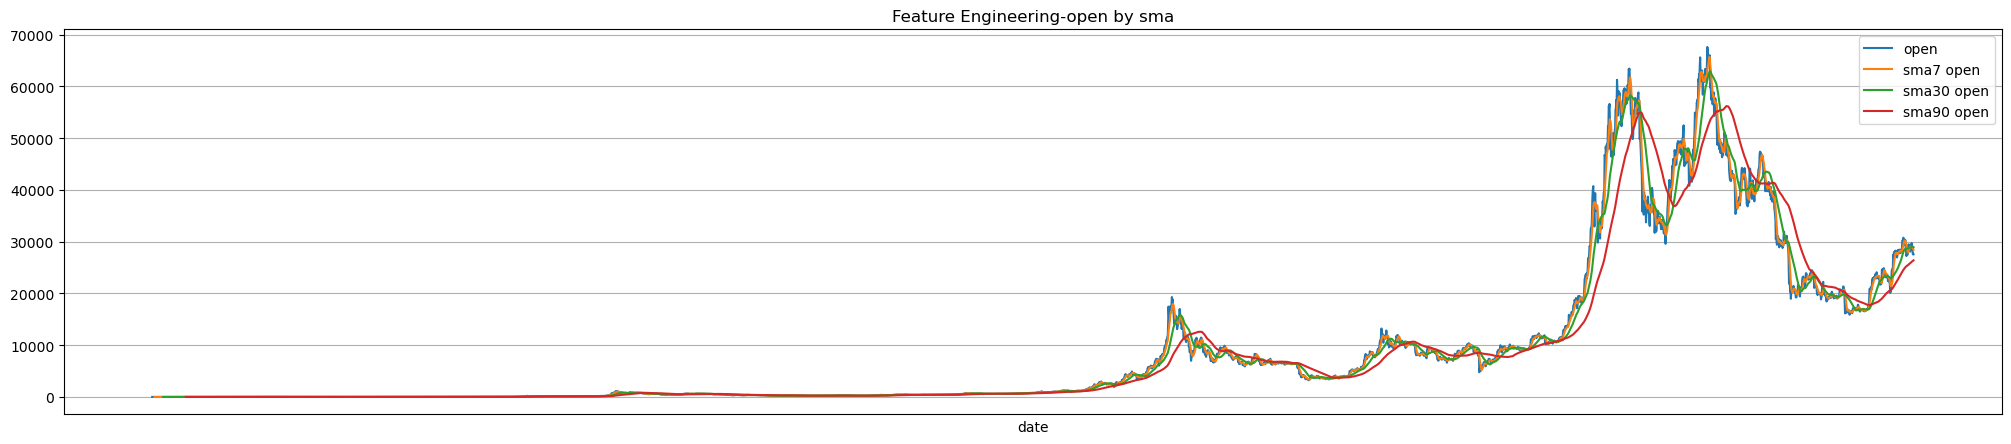

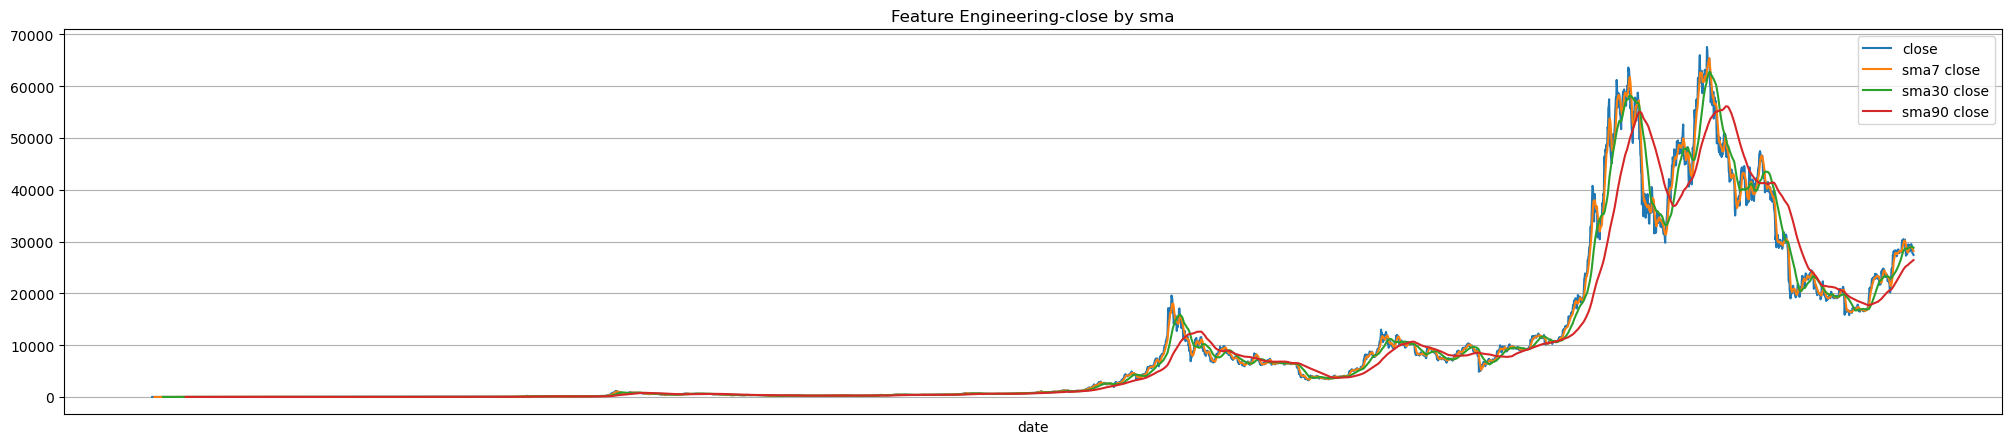

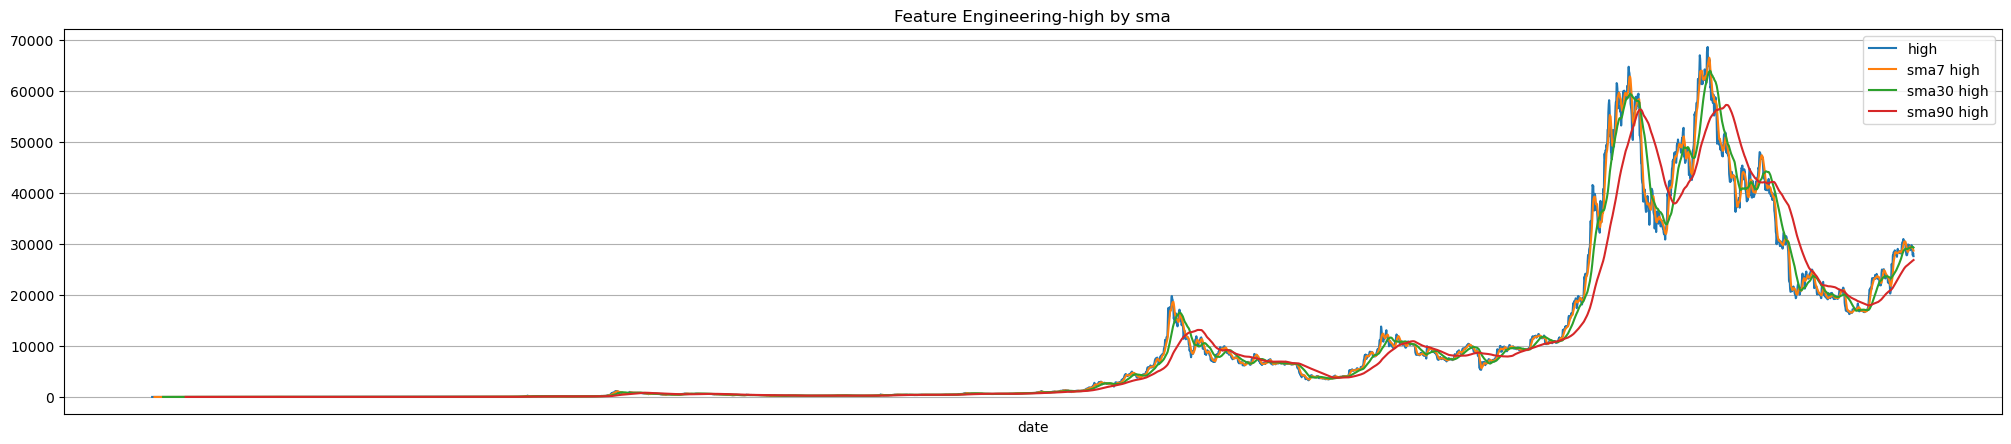

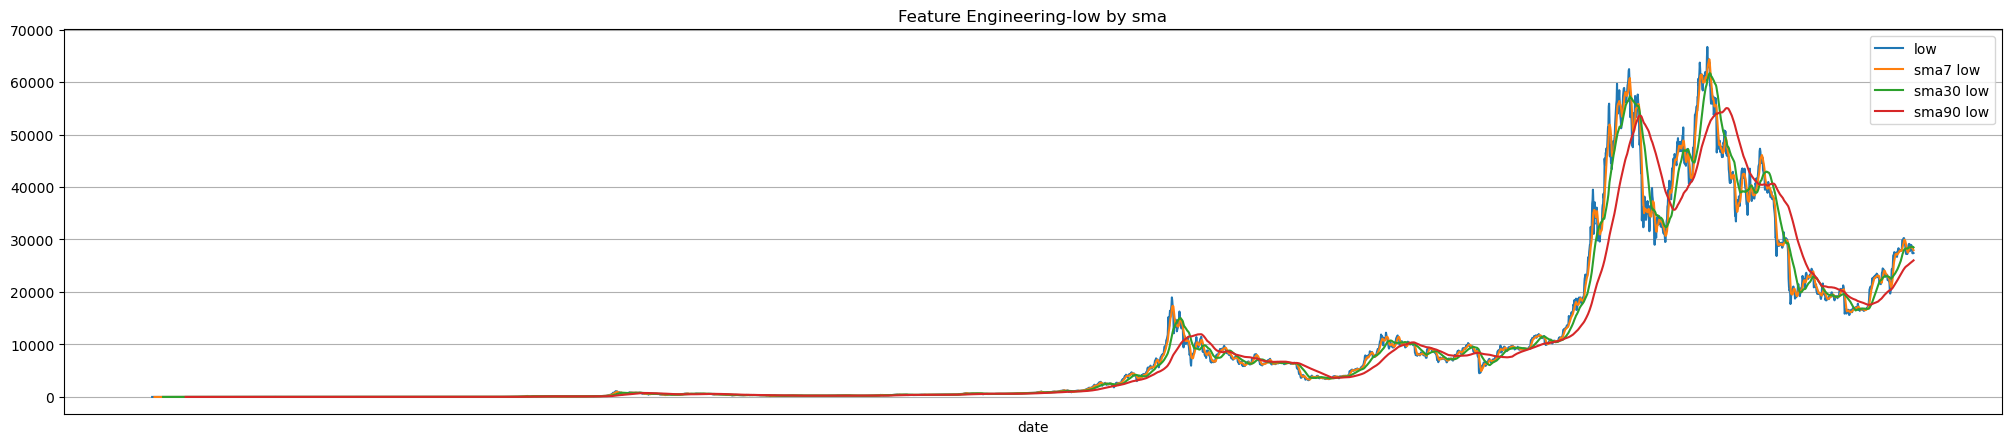

In [13]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'sma',show_plot=True)

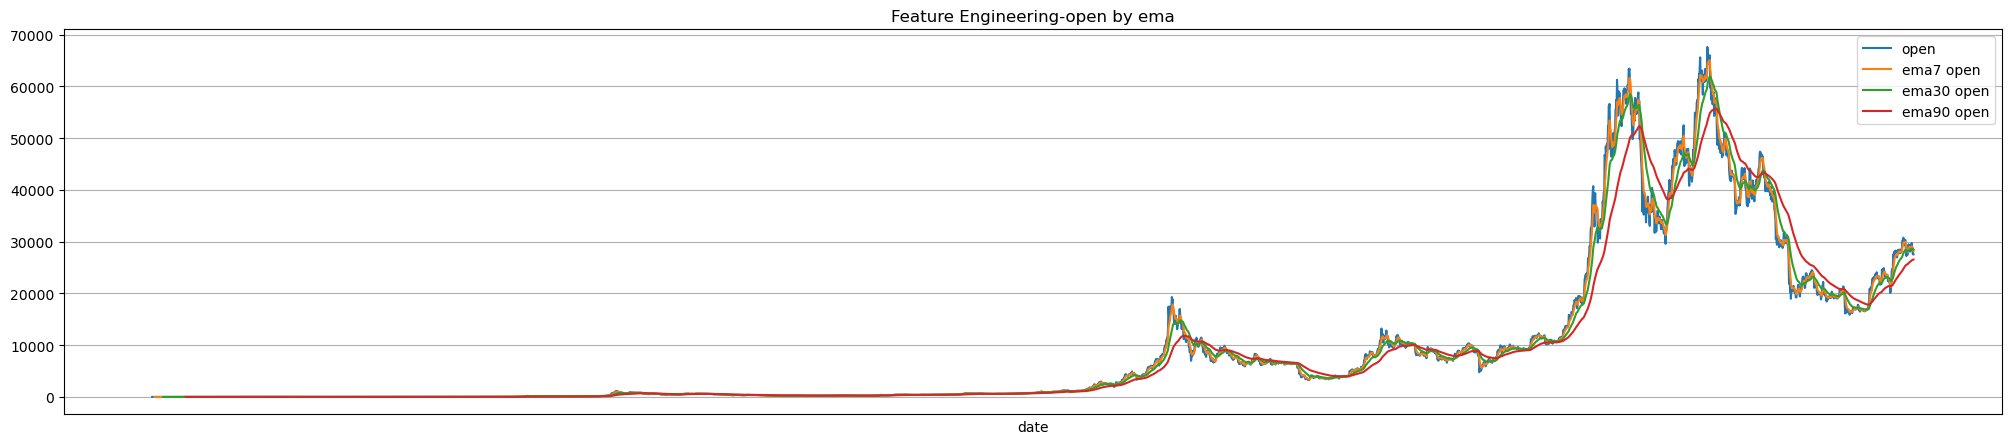

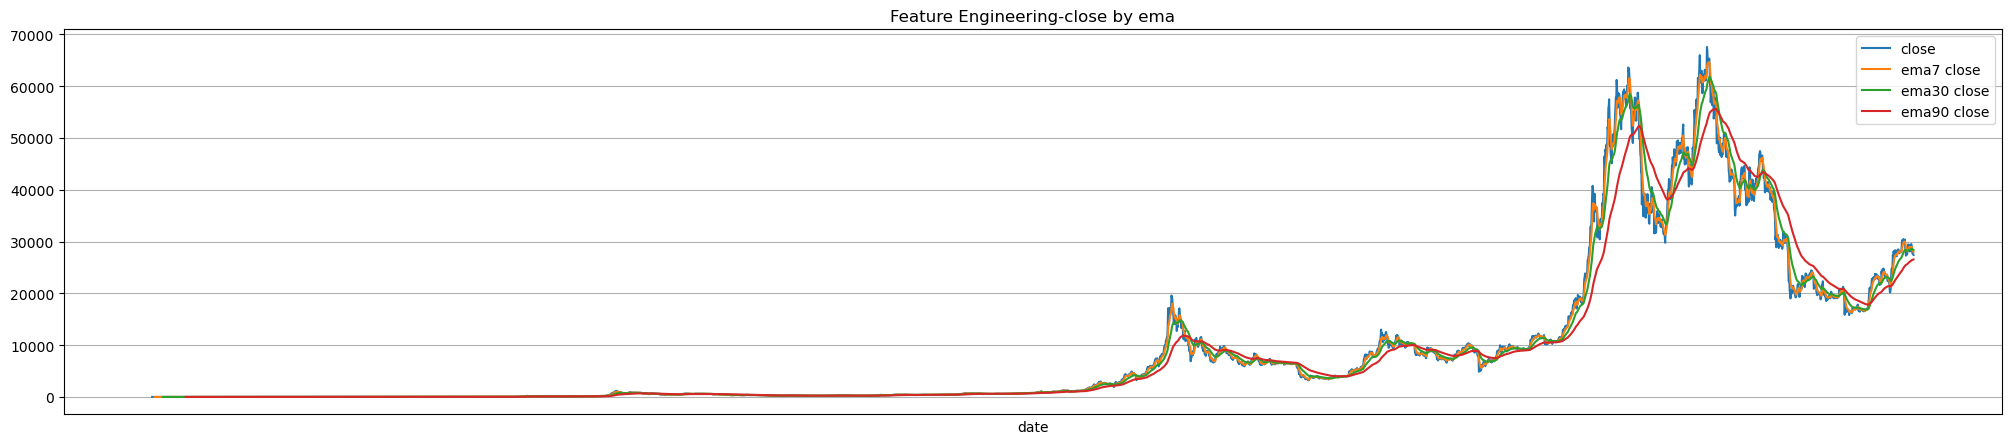

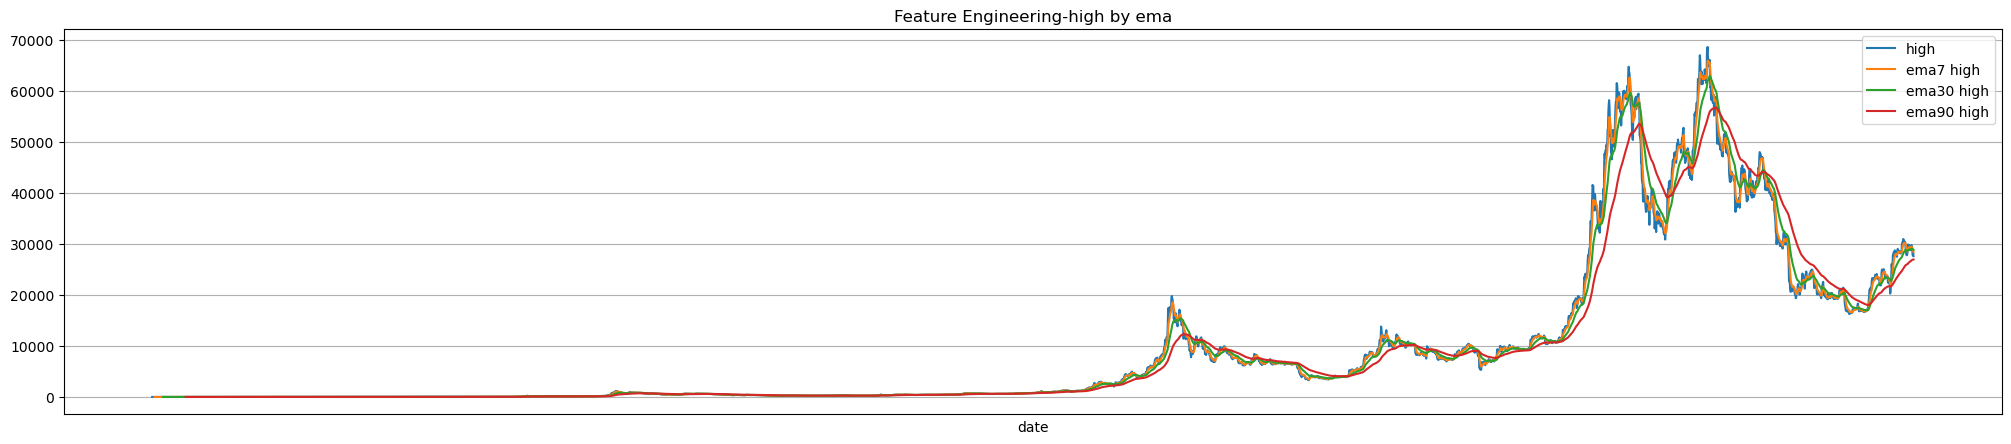

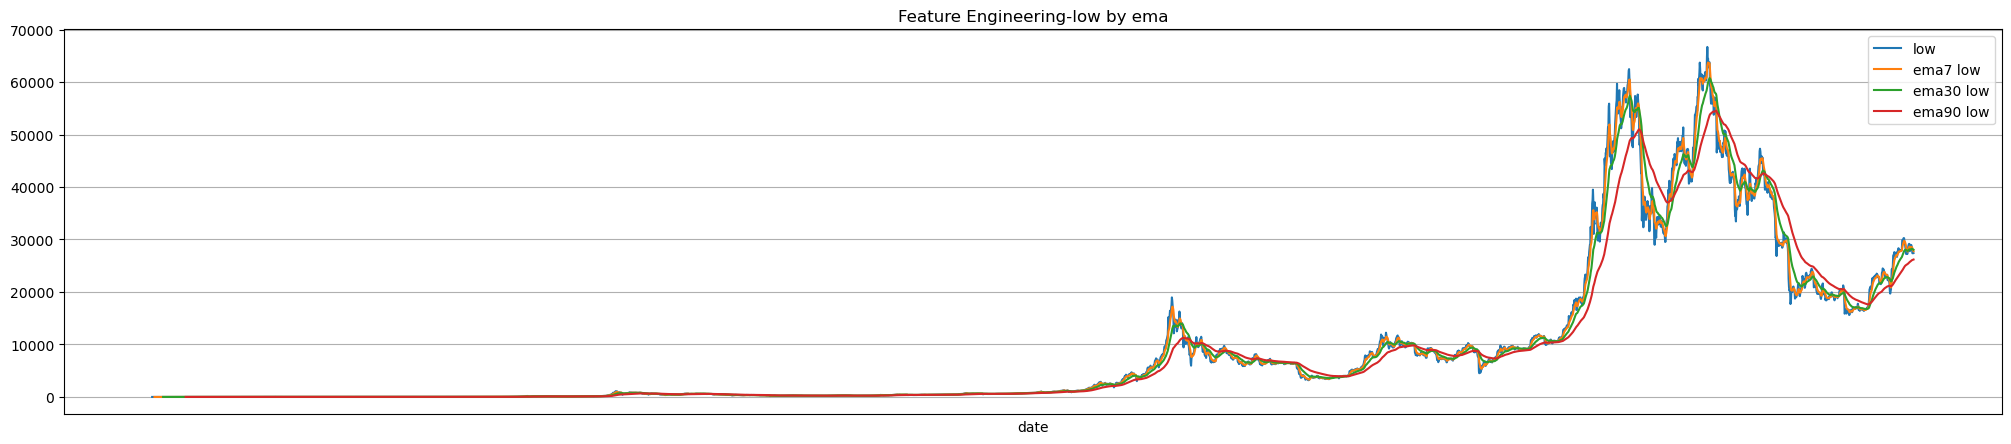

In [14]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'ema',show_plot=True)

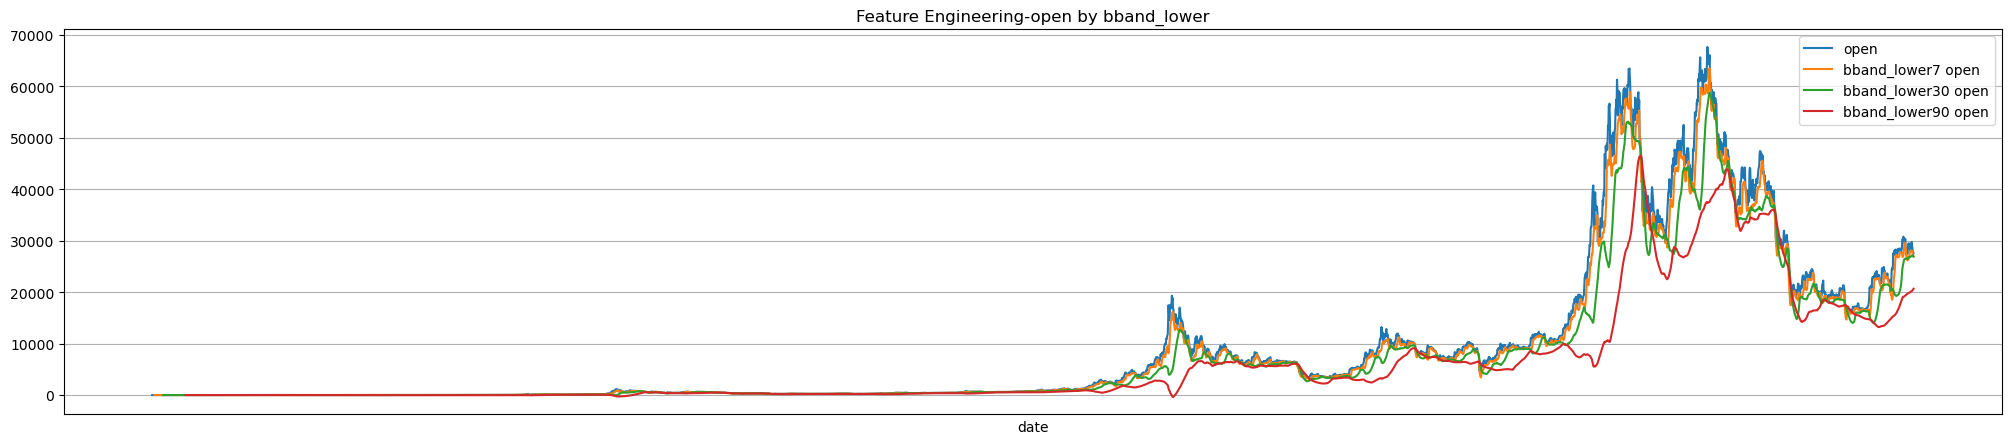

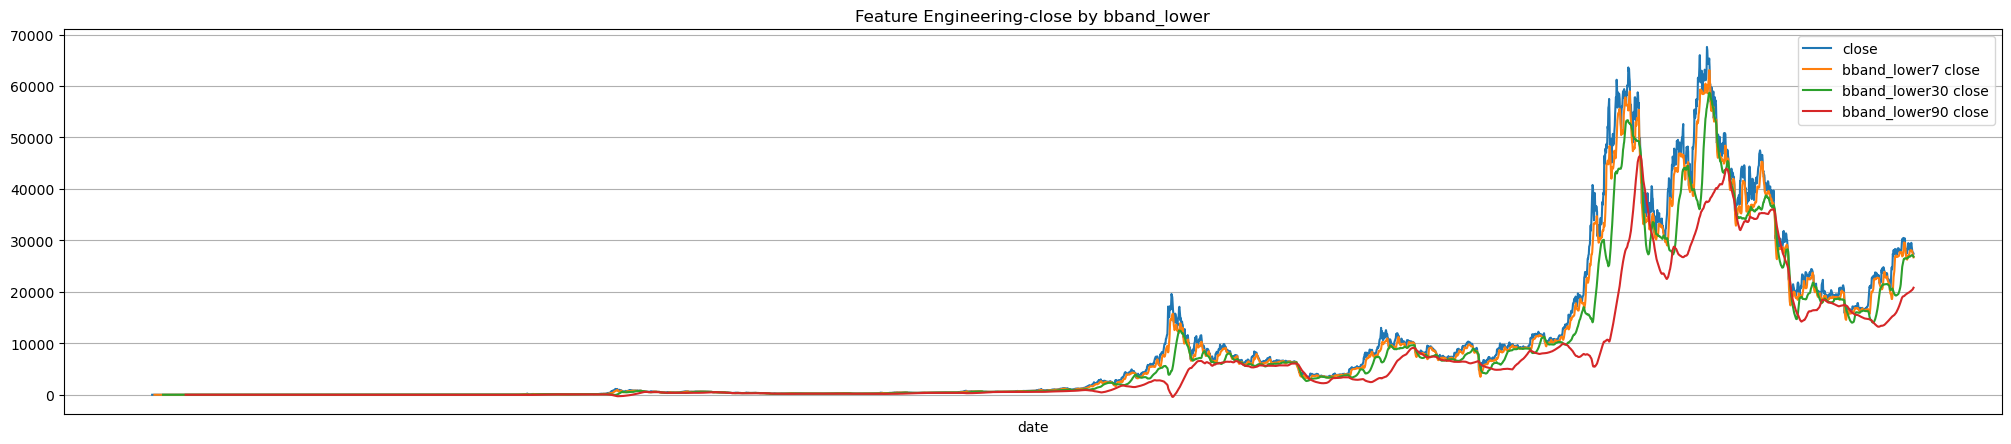

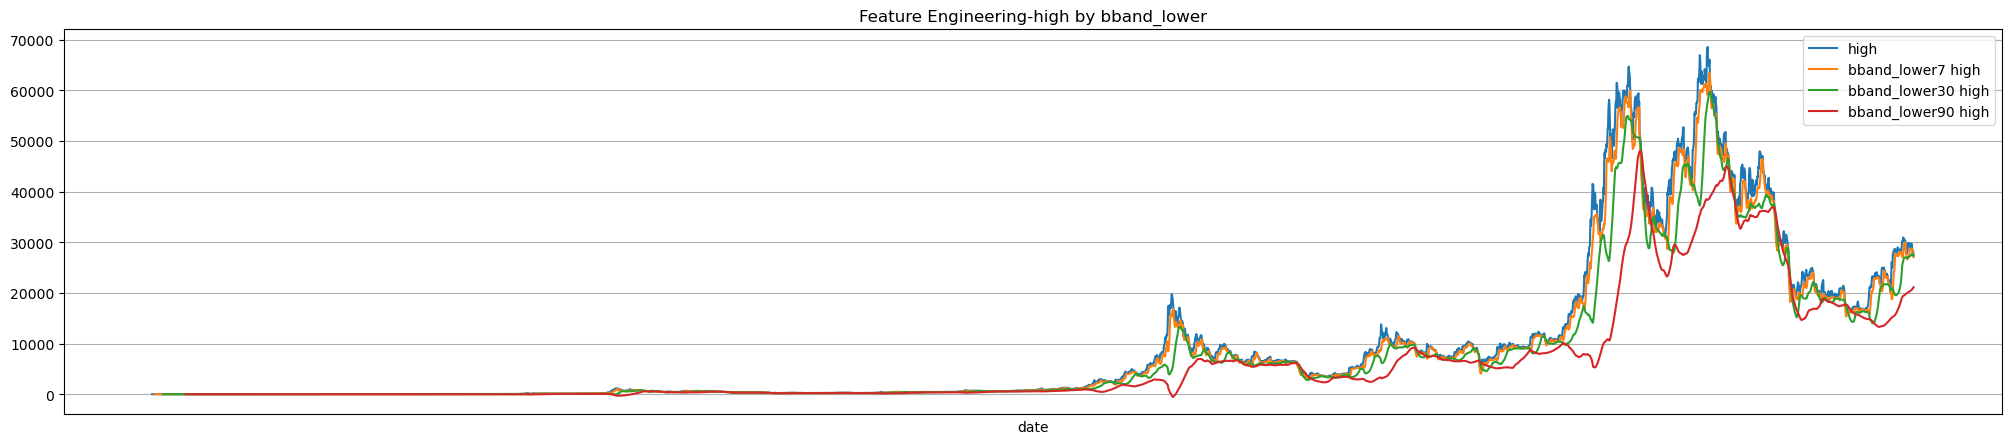

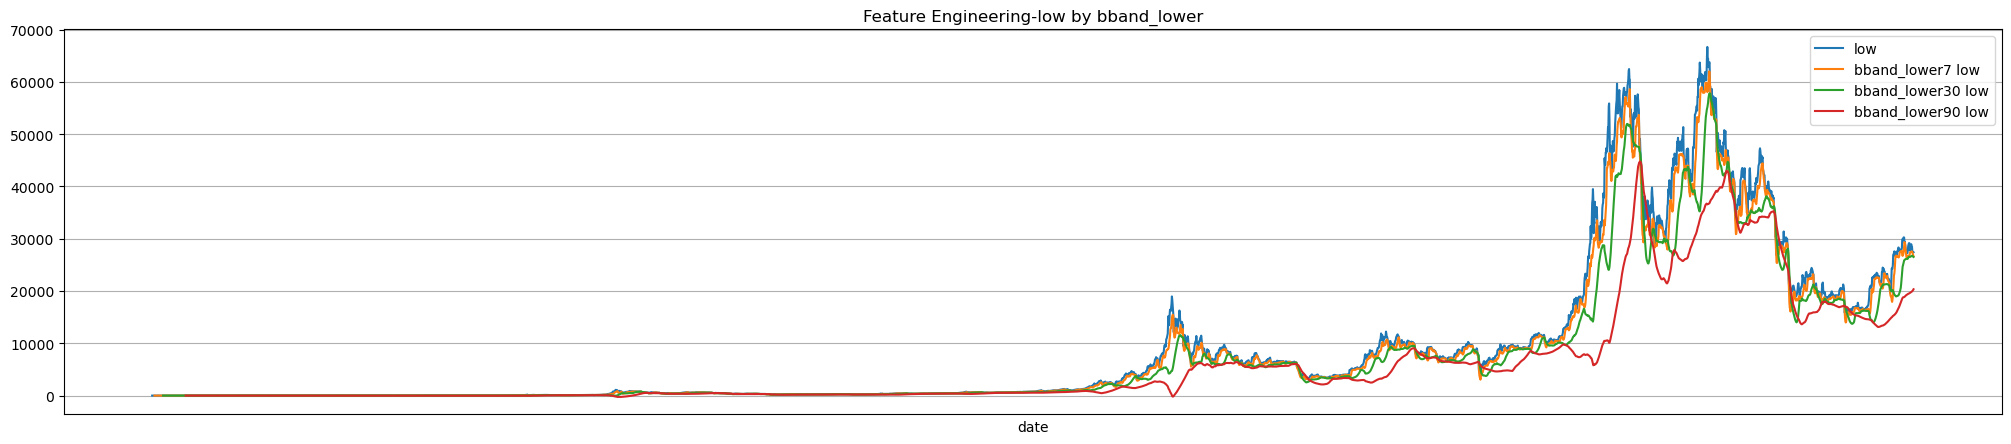

In [15]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'bband_lower',show_plot=True)

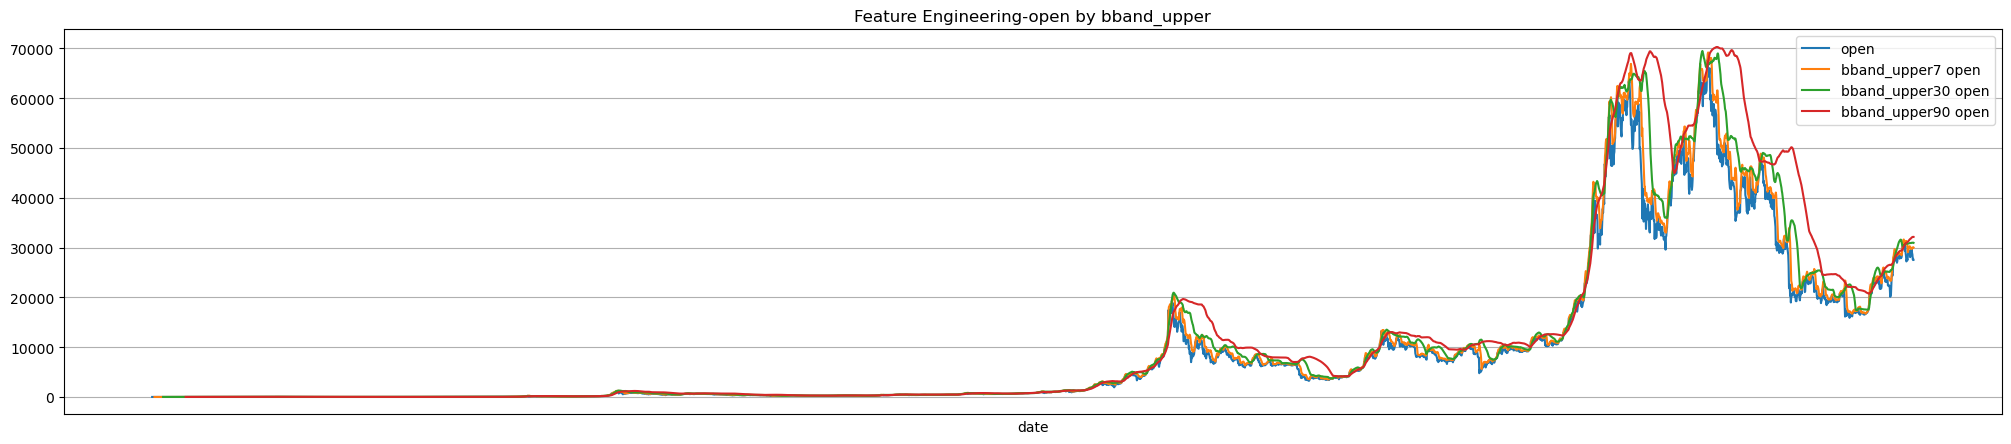

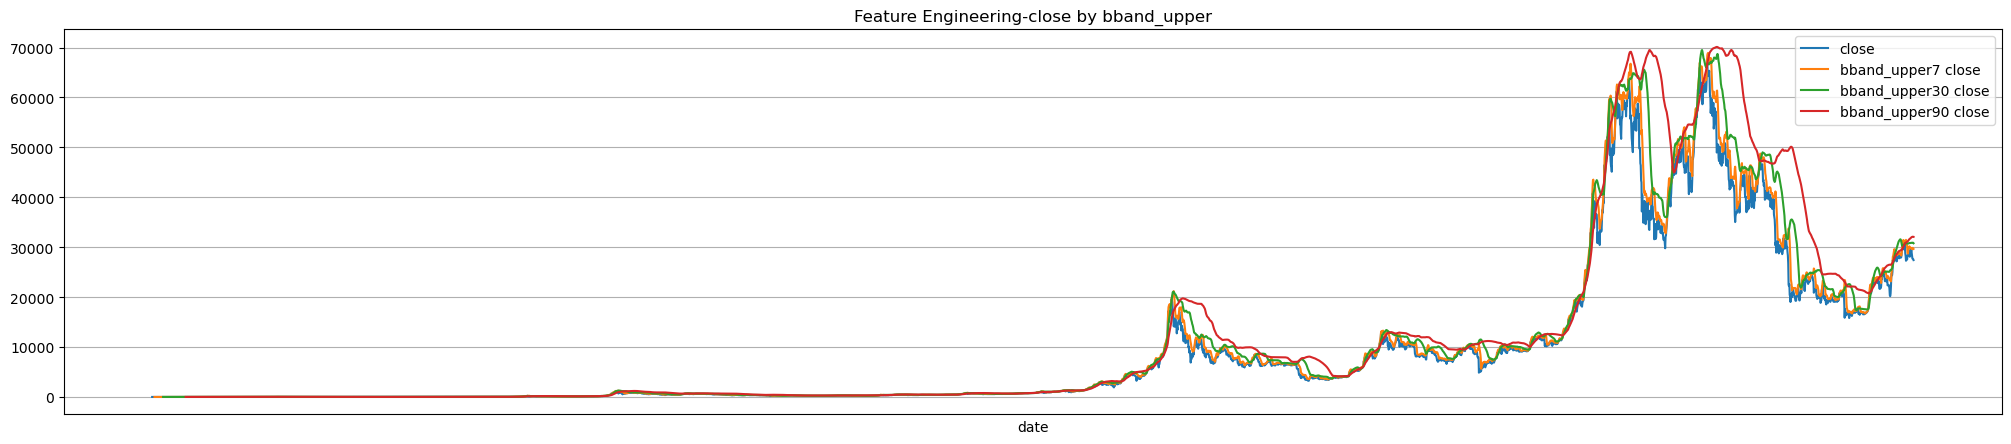

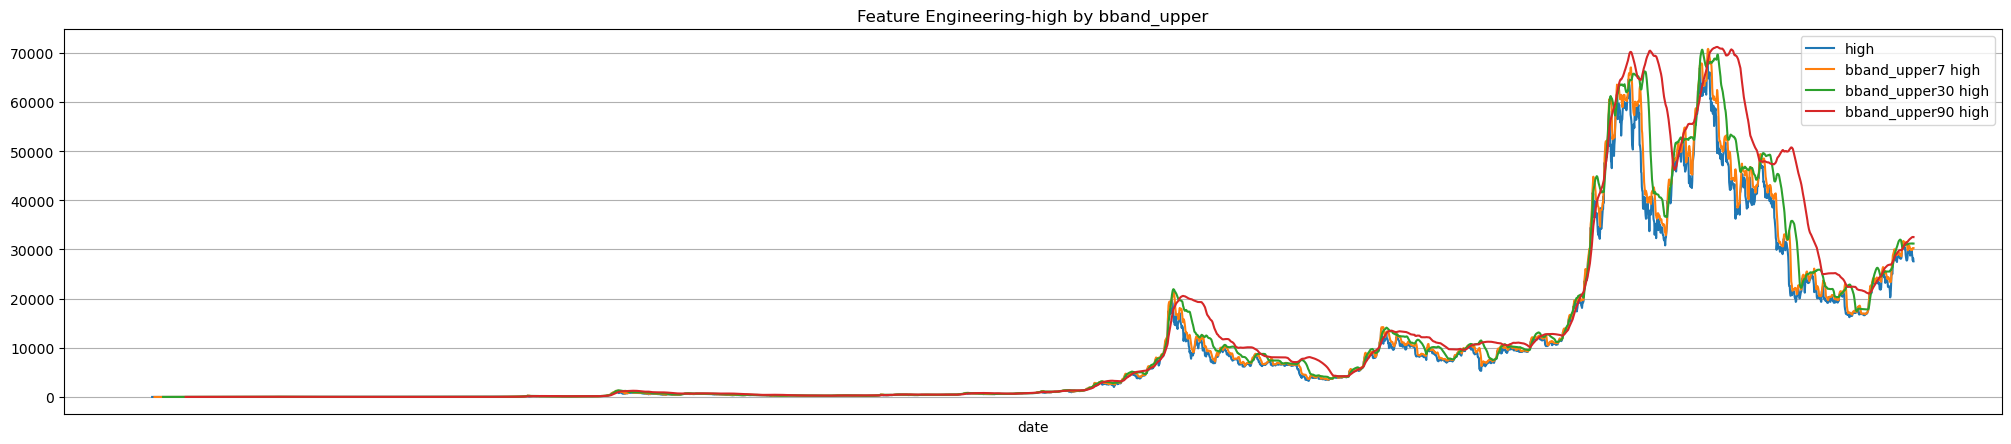

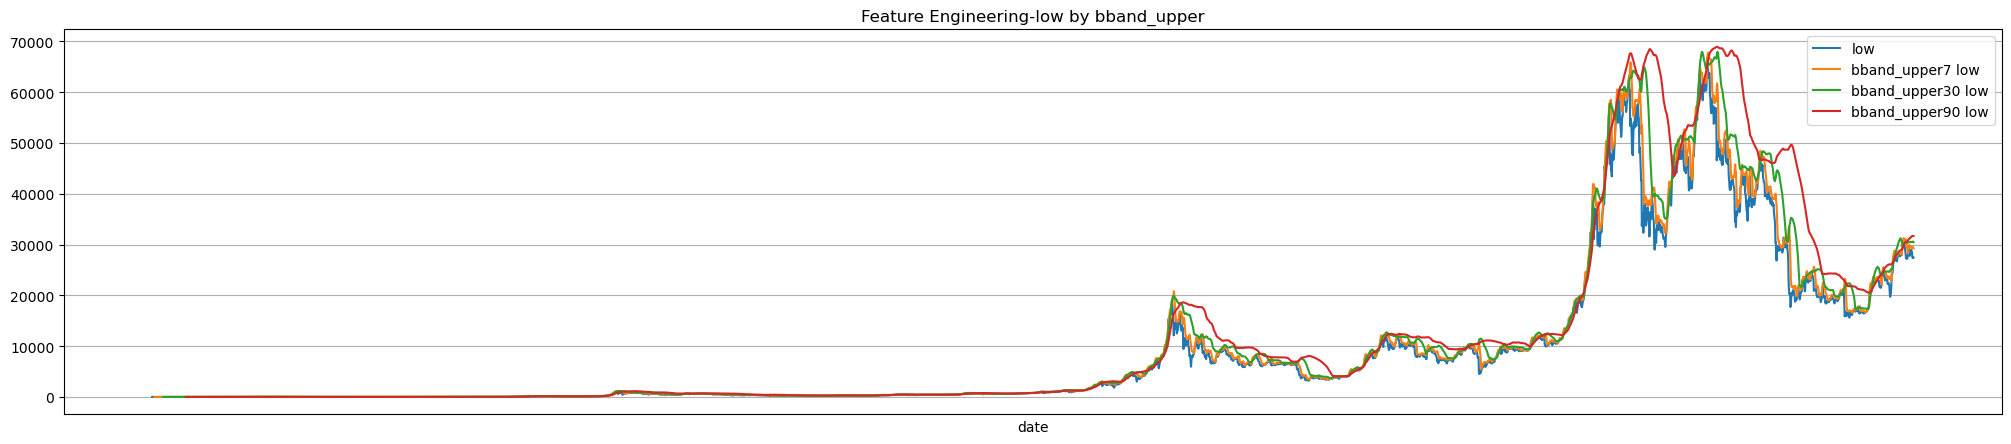

In [16]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'bband_upper',show_plot=True)

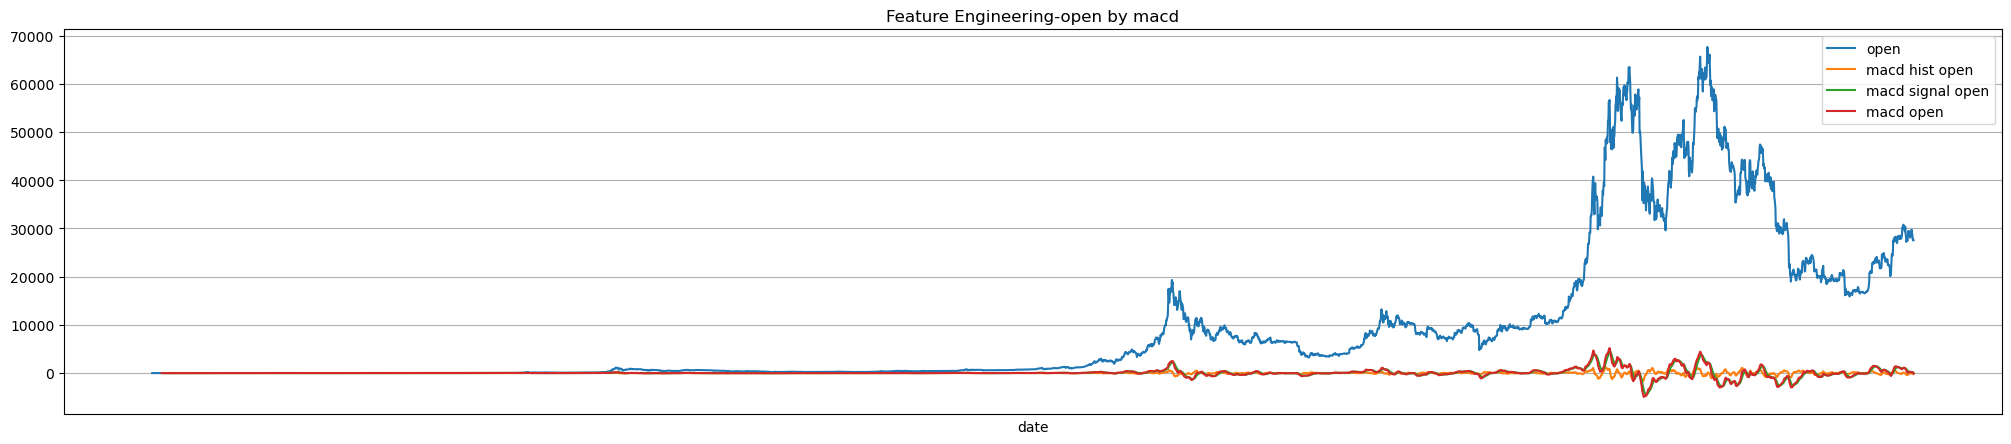

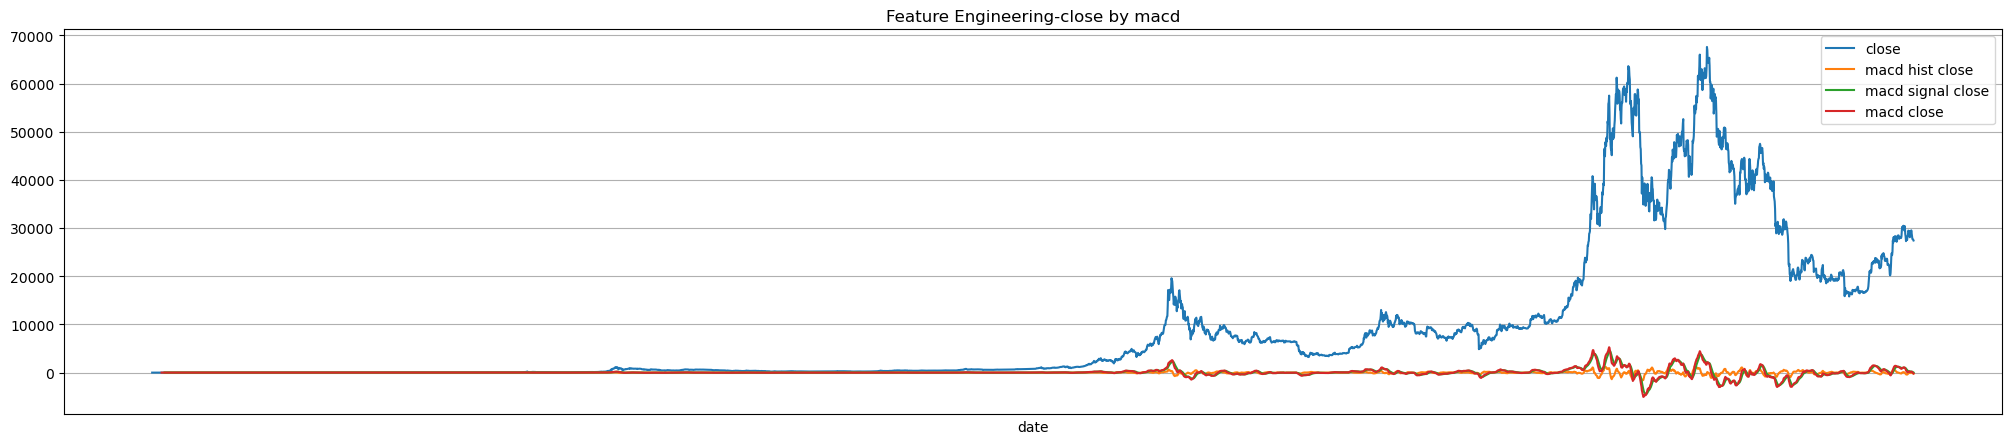

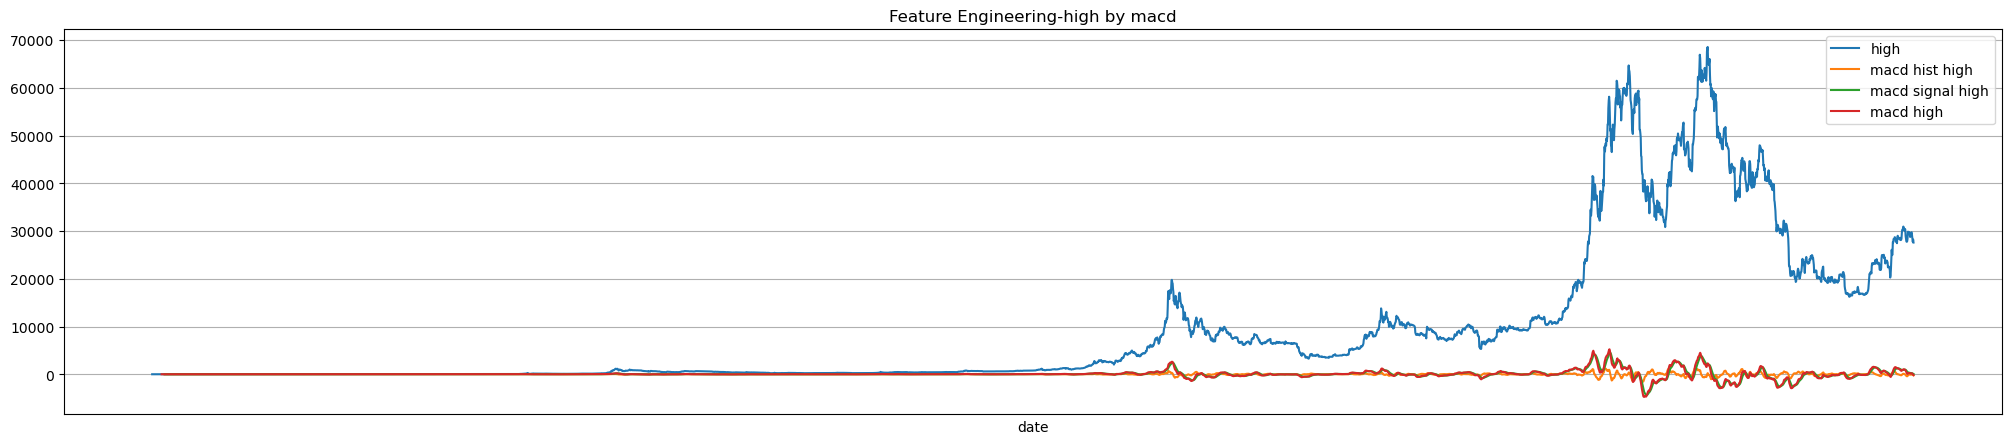

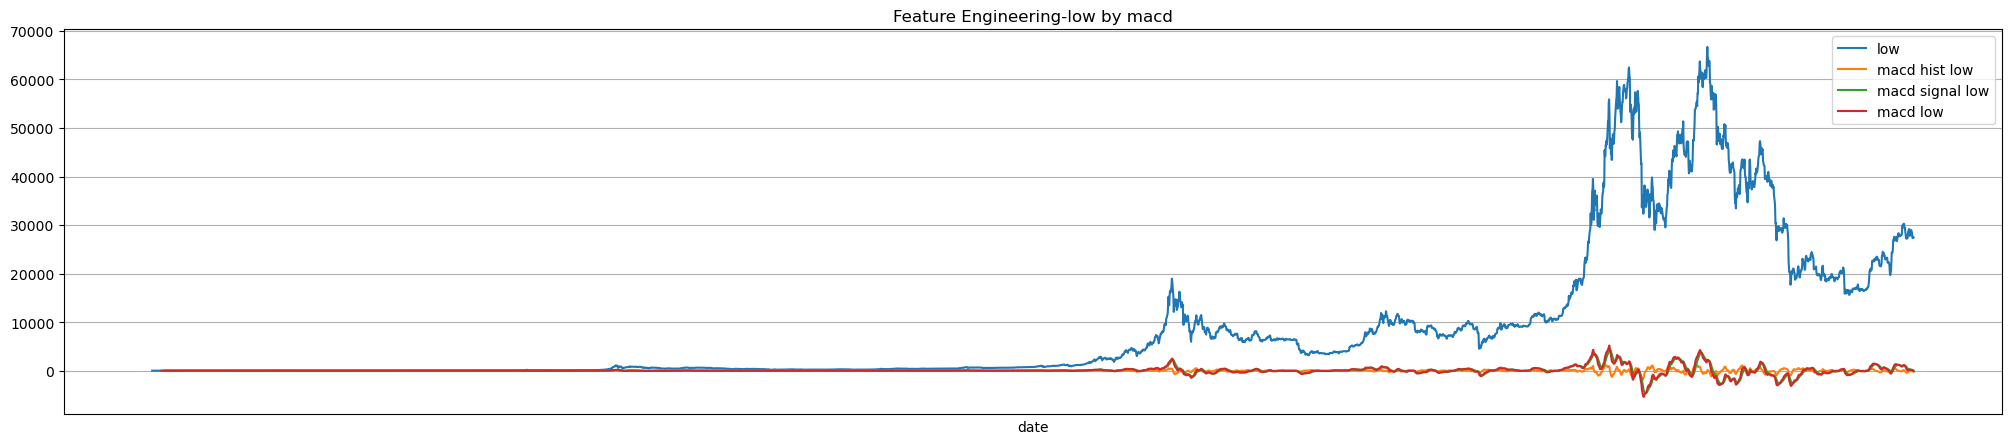

In [17]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'macd',show_plot=True)

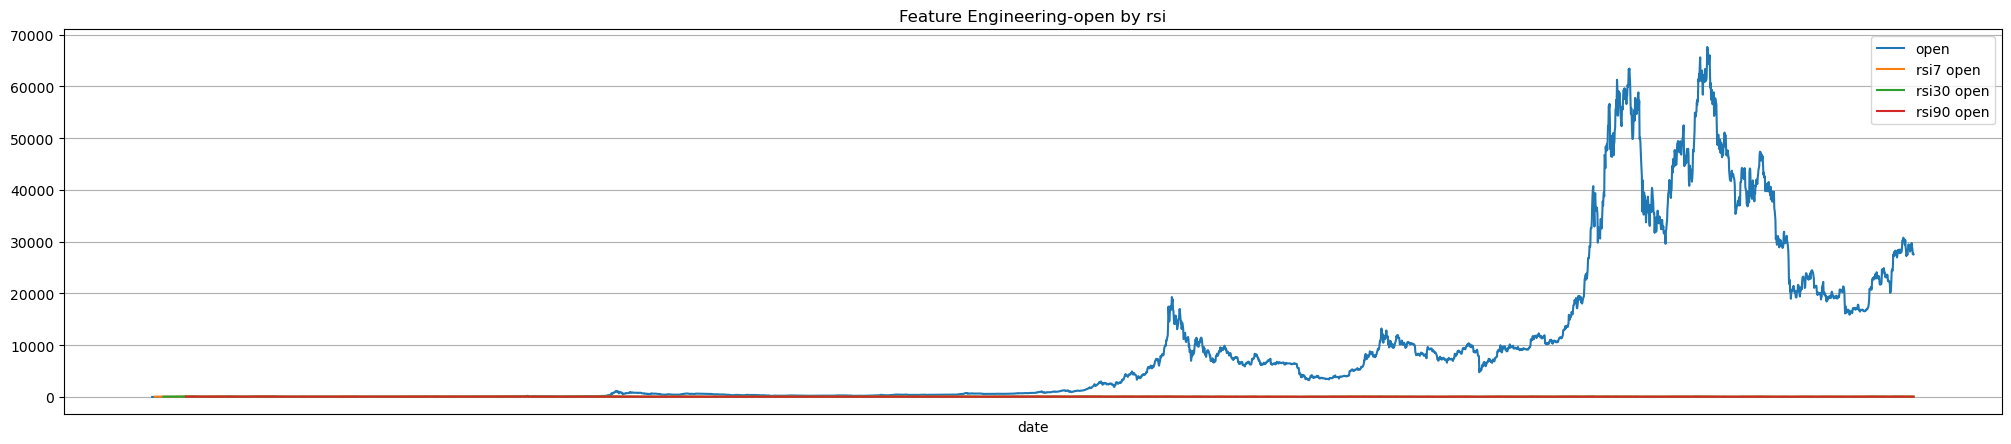

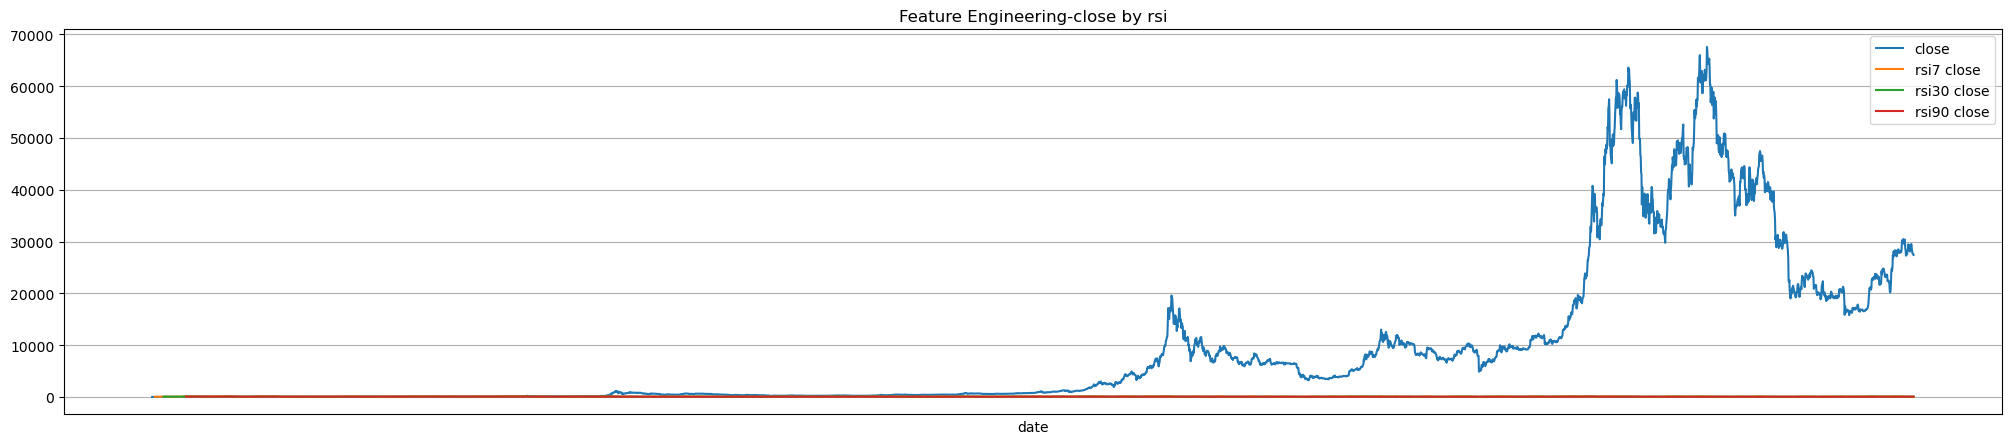

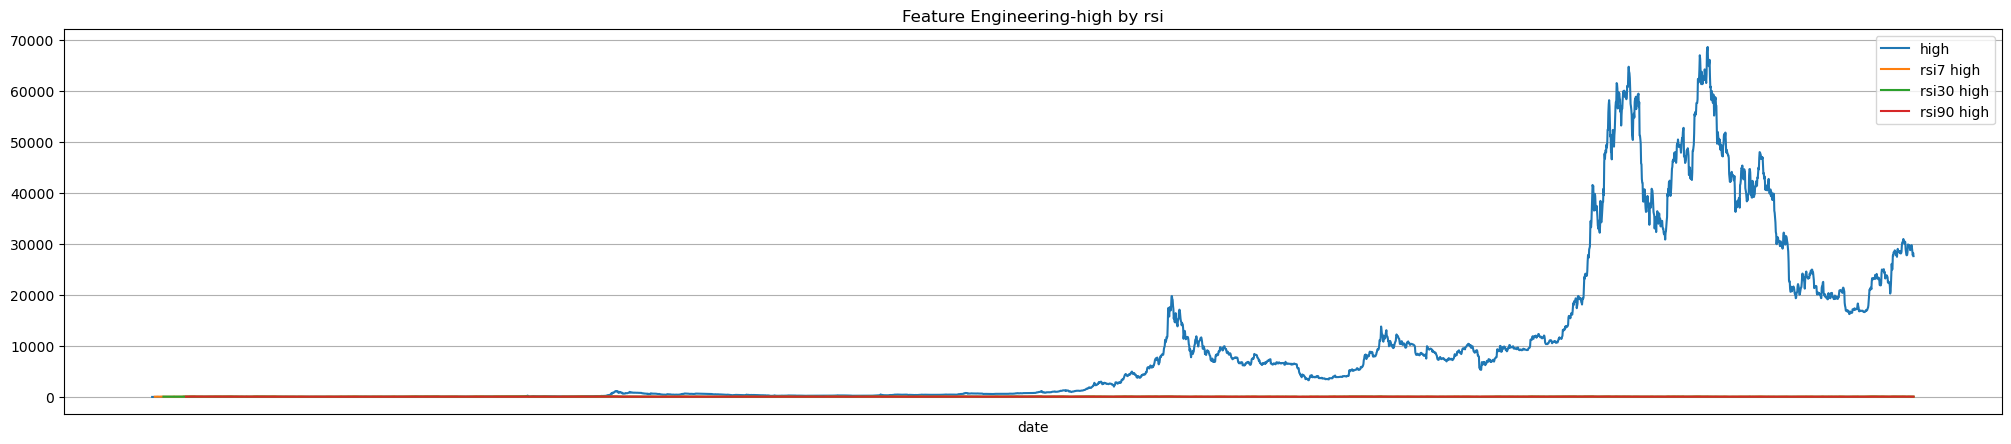

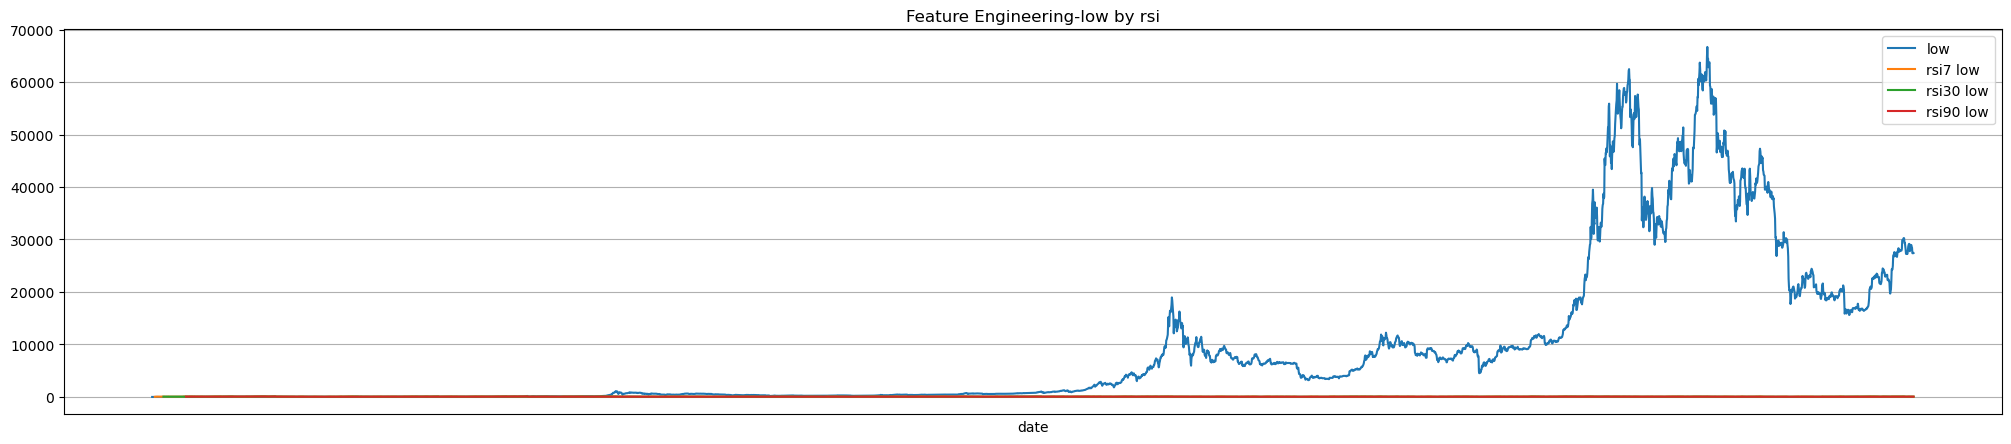

In [18]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'rsi',show_plot=True)

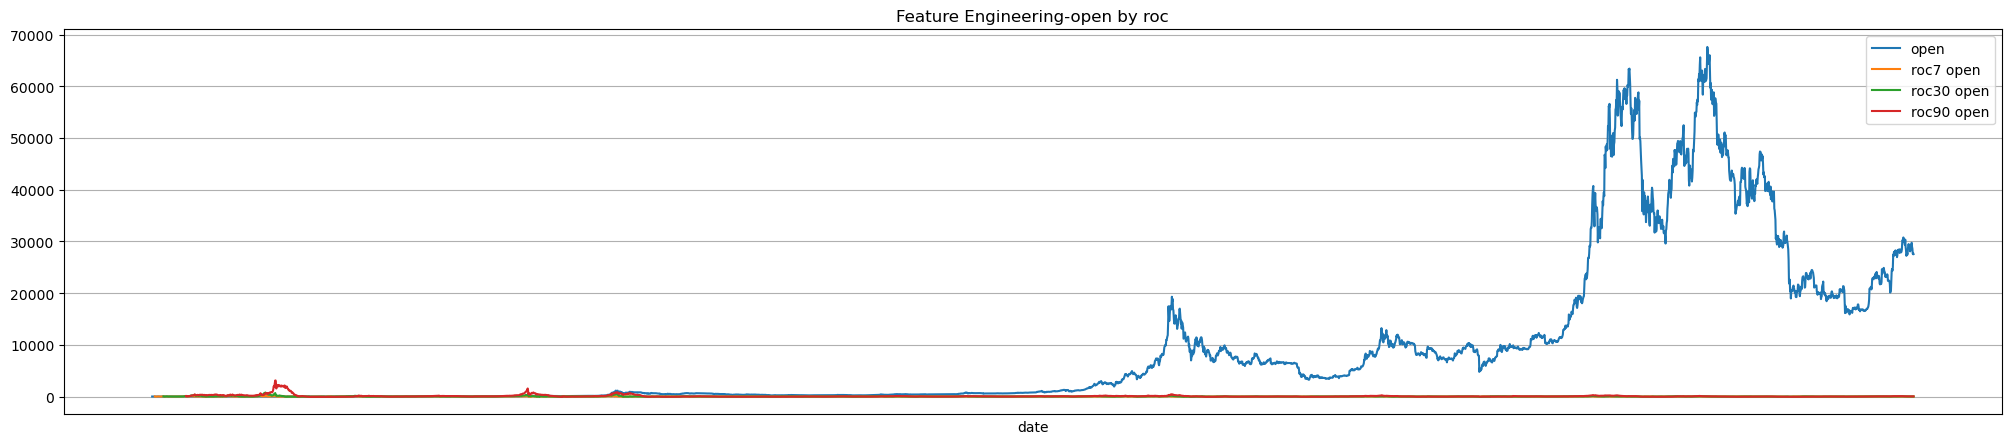

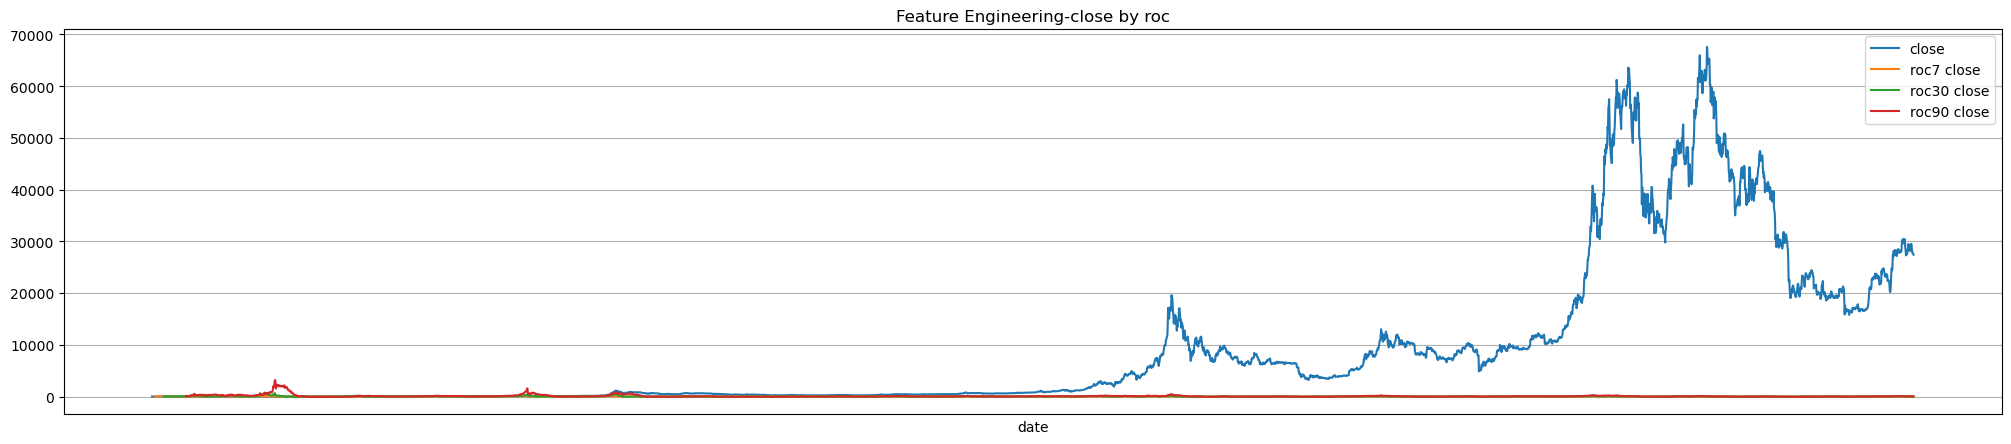

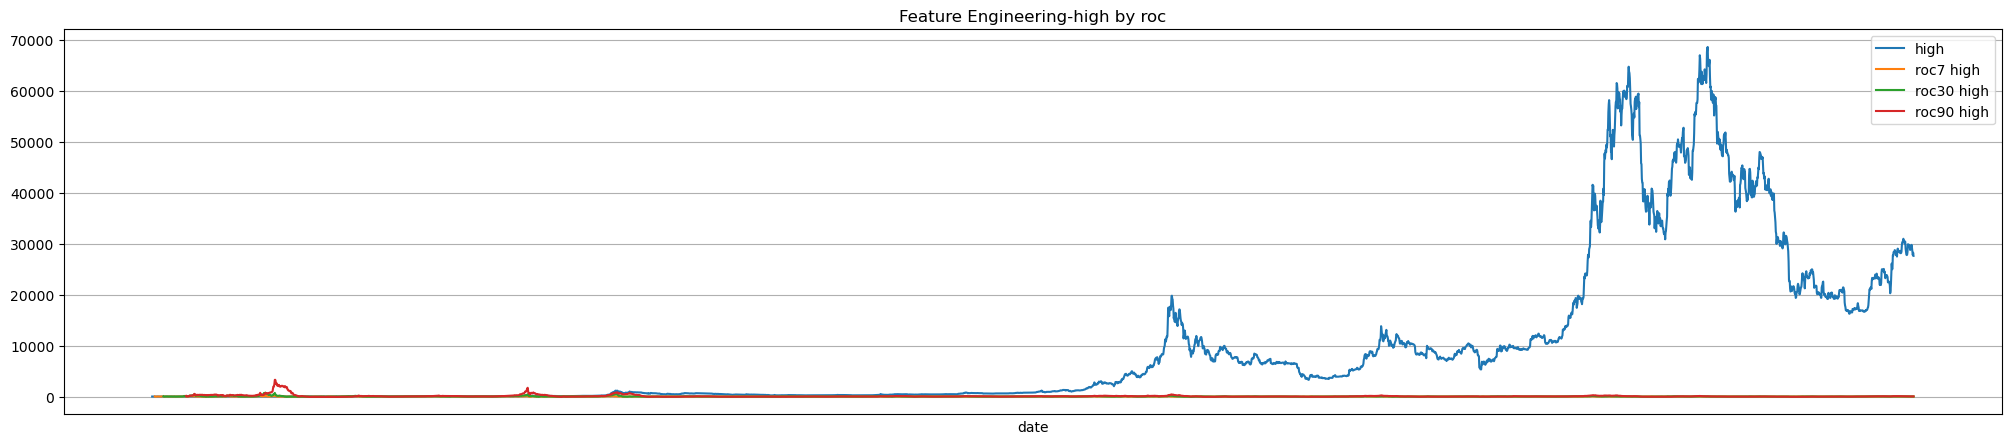

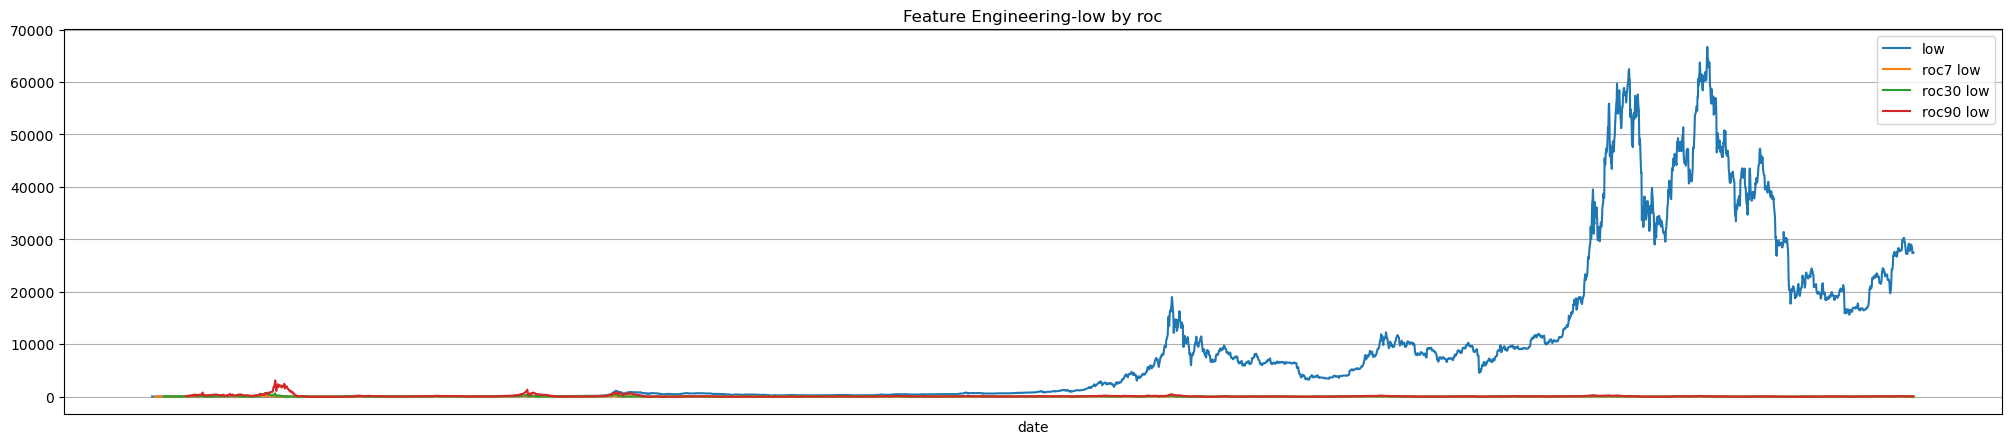

In [19]:
for feature in feature_list:
    feature_engineering(df_price_date,feature,'roc',show_plot=True)

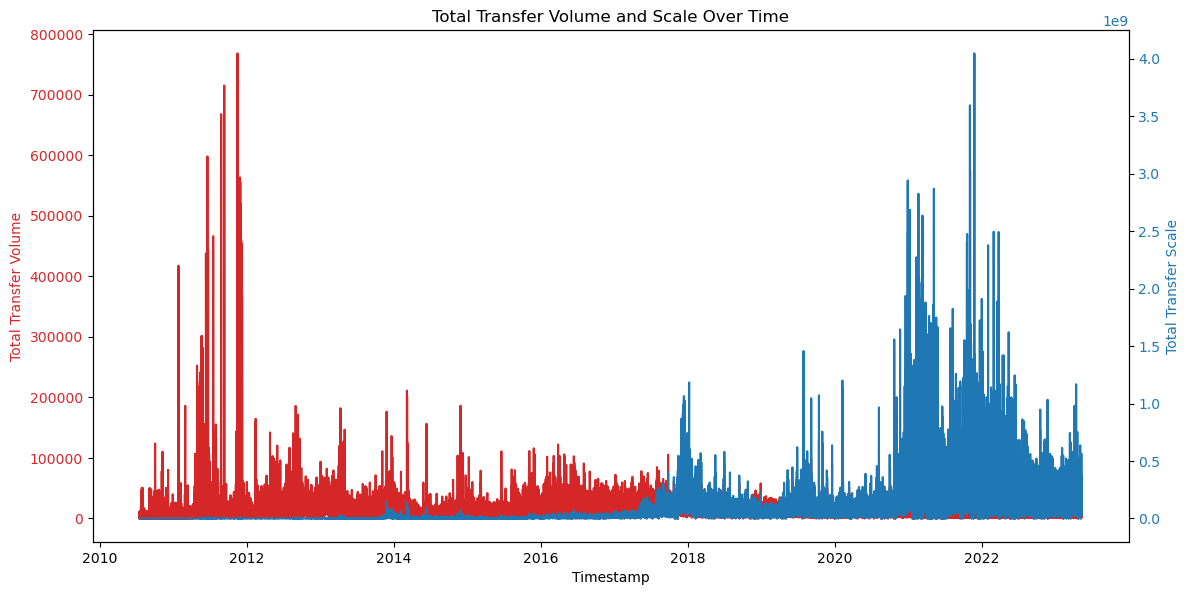

In [20]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total-transfer-volume and total-transfer-scale
color = 'tab:red'
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Total Transfer Volume', color=color)
ax1.plot(df_price['timestamp'], df_price['total-transfer-volume'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Total Transfer Scale', color=color)  
ax2.plot(df_price['timestamp'], df_price['total-transfer-scale'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Total Transfer Volume and Scale Over Time')
plt.show()

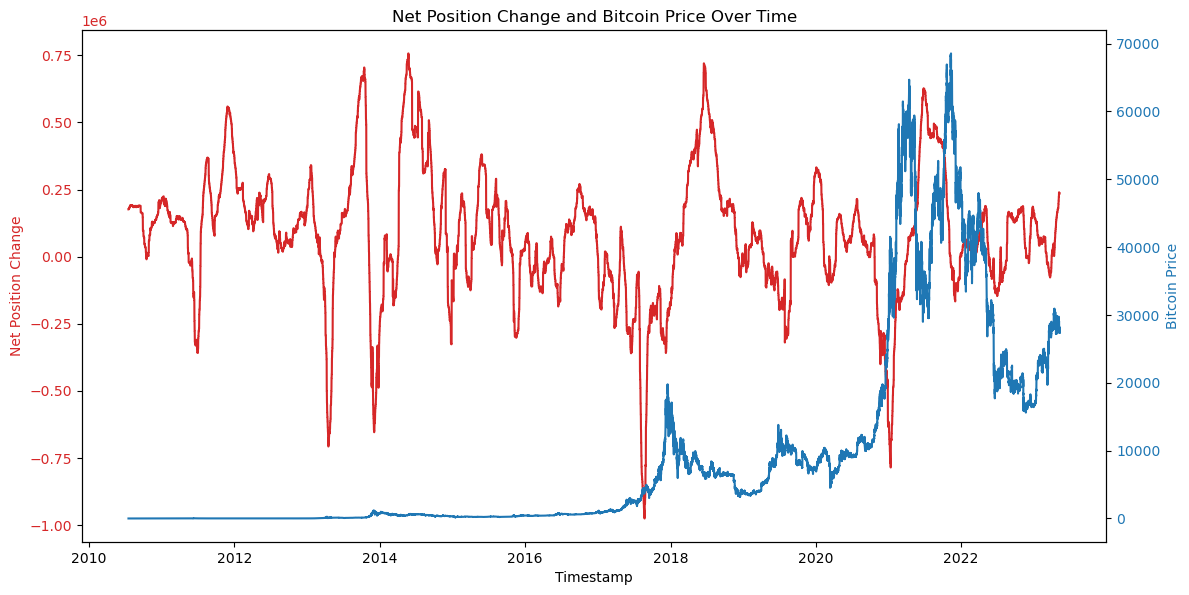

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot net_position_change
color = 'tab:red'
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Net Position Change', color=color)
ax1.plot(df_price['timestamp'], df_price['net_position_change'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Bitcoin Price', color=color)
ax2.plot(df_price['timestamp'], df_price['value'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.title('Net Position Change and Bitcoin Price Over Time')
plt.show()


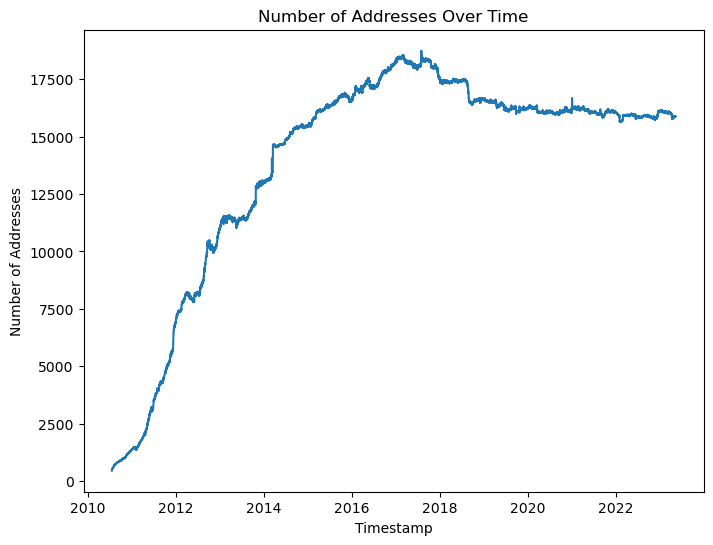

In [22]:
# Plot number_of_addresse
plt.figure(figsize=(8, 6))
plt.plot(df_price['timestamp'], df_price['number_of_addresse'])
plt.title('Number of Addresses Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Number of Addresses')
plt.show()


### Some interesting findings:
<br>1. In the early stage of Bitcoin issuance, the number of transactions was huge, but then decreased. This may be due to the low initial currency value, as can be seen from the 'Total Transfer Scale Over Time' graph on the right (Transfer Scale = Volume * Price).
<br>2. Net Position Change also seems to be a good signal. By comparing Net Position and bitcoin currency value changes, we can find that the two show a reverse trend, and the price response has a certain hysteresis, which is very simliar to the Herding Behavior and Anchoring Effect in traditional finance, and with the special properties of Bitcoin (mainly OTC), these effects may be exacerbated. In addition, the Loss Aversion and Disposition Effect is also obvious, and there have been many short-term panic sellings and buyings soon (the time interval is shorter than that of Long Postion).
<br>3. The transaction address peaked in 2018 and then stabilized in the region, which may be related to the limited supply of Bitcoin.

In [23]:
# Merge the dataframes
df_price['date'] = pd.to_datetime(df_price['date'])
df_price_date = df_price_date.drop(['open', 'close', 'high', 'low'], axis=1)
df_price_date.index = pd.to_datetime(df_price_date.index)

df = pd.merge(df_price, df_price_date, left_on='date', right_index=True)


In [24]:
# Now it's time to play with the NAs
missing_data = df.isnull().sum().reset_index()
missing_data.columns = ['Column', 'Missing Count']
missing_data_grouped = missing_data.groupby('Column').sum()
missing_data_grouped = missing_data_grouped.sort_values('Missing Count', ascending=False)
missing_data_grouped
# Seems a lot

Missing Count
Column                                
rsi90 open                        2137
roc90 high                        2137
rsi90 high                        2137
rsi90 close                       2137
roc90 close                       2137
...                                ...
low                                  0
number_of_addresse                   0
open                                 0
prev_number_of_addresse              0
value                                0

[113 rows x 1 columns]

In [25]:
df = df[df['date'] > '2010-10-17']

In [26]:
# backward fill the missing values
df = df.fillna(method='bfill')

In [27]:
# Get a DataFrame with True at places where there is a missing value
missing_value_mask = df.isna()

timestamps_with_missing_values = df['timestamp'][missing_value_mask.any(axis=1)]
timestamps_with_missing_values

112297   2023-05-10 00:00:00+00:00
112298   2023-05-10 01:00:00+00:00
112299   2023-05-10 02:00:00+00:00
112300   2023-05-10 03:00:00+00:00
112301   2023-05-10 04:00:00+00:00
112302   2023-05-10 05:00:00+00:00
112303   2023-05-10 06:00:00+00:00
112304   2023-05-10 07:00:00+00:00
112305   2023-05-10 08:00:00+00:00
112306   2023-05-10 09:00:00+00:00
112307   2023-05-10 10:00:00+00:00
112308   2023-05-10 11:00:00+00:00
112309   2023-05-10 12:00:00+00:00
112310   2023-05-10 13:00:00+00:00
112311   2023-05-10 14:00:00+00:00
112312   2023-05-10 15:00:00+00:00
112313   2023-05-10 16:00:00+00:00
112314   2023-05-10 17:00:00+00:00
112315   2023-05-10 18:00:00+00:00
112316   2023-05-10 19:00:00+00:00
112317   2023-05-10 20:00:00+00:00
112318   2023-05-10 21:00:00+00:00
112319   2023-05-10 22:00:00+00:00
112320   2023-05-10 23:00:00+00:00
112321   2023-05-11 00:00:00+00:00
112322   2023-05-11 01:00:00+00:00
112323   2023-05-11 02:00:00+00:00
112324   2023-05-11 03:00:00+00:00
112325   2023-05-11 

In [28]:
# only the lastest 2 days have missing values, drop 'em
df = df.dropna()

In [29]:
# Aagin, check on missing values
missing_data = df.isnull().sum().reset_index()
missing_data.columns = ['Column', 'Missing Count']
missing_data_grouped = missing_data.groupby('Column').sum()
missing_data_grouped
missing_data_grouped = missing_data_grouped.sort_values('Missing Count', ascending=False)
missing_data_grouped

Missing Count
Column                            
bband_lower30 close              0
prev_01_1                        0
roc90 open                       0
roc90 low                        0
roc90 high                       0
...                            ...
ema90 close                      0
ema7 open                        0
ema7 low                         0
ema7 high                        0
value                            0

[113 rows x 1 columns]

Well, now it looks much better ;)

In [30]:
# Finalize the dataset for training
# drop all the columns that we cannot access at the time we predict
df_final = df.drop(['time_diff','date','open', 'close', 'high', 'low','number_of_addresse','total-transfer-volume','net_position_change','total-transfer-scale'], axis=1)
df_final

timestamp         value     prev_open    prev_close   
2209   2010-10-18 00:00:00+00:00      0.102000      0.101000      0.102000  \
2210   2010-10-18 01:00:00+00:00      0.102000      0.101000      0.102000   
2211   2010-10-18 02:00:00+00:00      0.103000      0.101000      0.102000   
2212   2010-10-18 03:00:00+00:00      0.102000      0.101000      0.102000   
2213   2010-10-18 04:00:00+00:00      0.102000      0.101000      0.102000   
...                          ...           ...           ...           ...   
112292 2023-05-09 19:00:00+00:00  27654.374443  28597.833708  27716.367263   
112293 2023-05-09 20:00:00+00:00  27642.341848  28597.833708  27716.367263   
112294 2023-05-09 21:00:00+00:00  27640.286058  28597.833708  27716.367263   
112295 2023-05-09 22:00:00+00:00  27577.716353  28597.833708  27716.367263   
112296 2023-05-09 23:00:00+00:00  27652.946630  28597.833708  27716.367263   

           prev_high      prev_low  prev_number_of_addresse   
2209        0.104500      0.100010                    967.0  \
2210        0.104500      0.100010                    967.0   
2211        0.104500      0.100010                    967.0   
2212        0.104500      0.100010                    966.0   
2213        0.104500      0.100010                    966.0   
...              ...           ...                      ...   
112292  28597.833708  27384.168209                  15876.0   
112293  28597.833708  27384.168209                  15875.0   
112294  28597.833708  27384.168209                  15875.0   
112295  28597.833708  27384.168209                  15878.0   
112296  28597.833708  27384.168209                  15882.0   

        prev_total-transfer-volume  prev_net_position_change  prev_0001_001   
2209                   1535.030000              13499.106409        0.00000  \
2210                    254.530000              13499.106409        0.00000   
2211                   1149.110000              13499.106409        0.00000   
2212                    228.050000              13499.106409        0.00000   
2213                  10073.510000              13499.106409        0.00000   
...                            ...                       ...            ...   
112292                 3283.273403             236875.504964        0.00212   
112293                11195.802709             236875.504964        0.00212   
112294                 5395.681867             236875.504964        0.00212   
112295                 3495.142087             236875.504964        0.00212   
112296                 3328.758492             236875.504964        0.00212   

        ...  roc90 open  roc7 close  roc30 close  roc90 close  roc7 high   
2209    ...   26.237624    7.789474    67.868852    37.020517   1.477833  \
2210    ...   26.237624    7.789474    67.868852    37.020517   1.477833   
2211    ...   26.237624    7.789474    67.868852    37.020517   1.477833   
2212    ...   26.237624    7.789474    67.868852    37.020517   1.477833   
2213    ...   26.237624    7.789474    67.868852    37.020517   1.477833   
...     ...         ...         ...          ...          ...        ...   
112292  ...   18.273769   -3.474621    -2.425759    20.513432  -3.487917   
112293  ...   18.273769   -3.474621    -2.425759    20.513432  -3.487917   
112294  ...   18.273769   -3.474621    -2.425759    20.513432  -3.487917   
112295  ...   18.273769   -3.474621    -2.425759    20.513432  -3.487917   
112296  ...   18.273769   -3.474621    -2.425759    20.513432  -3.487917   

        roc30 high  roc90 high  roc7 low  roc30 low  roc90 low  
2209     68.852459   25.901479   9.89011  71.713125  34.661998  
2210     68.852459   25.901479   9.89011  71.713125  34.661998  
2211     68.852459   25.901479   9.89011  71.713125  34.661998  
2212     68.852459   25.901479   9.89011  71.713125  34.661998  
2213     68.852459   25.901479   9.89011  71.713125  34.661998  
...            ...         ...       ...        ...        ...  
112292   -2.

## Modeling
<br>I decide to use MAE, RMSE and R2 to test the modeling results, as well as the plot.
<br>As for the model, I decide to use random forest

In [31]:
def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    return MAE,RMSE

In [32]:
df_final = df_final.set_index('timestamp')
df_final

value     prev_open    prev_close   
timestamp                                                             
2010-10-18 00:00:00+00:00      0.102000      0.101000      0.102000  \
2010-10-18 01:00:00+00:00      0.102000      0.101000      0.102000   
2010-10-18 02:00:00+00:00      0.103000      0.101000      0.102000   
2010-10-18 03:00:00+00:00      0.102000      0.101000      0.102000   
2010-10-18 04:00:00+00:00      0.102000      0.101000      0.102000   
...                                 ...           ...           ...   
2023-05-09 19:00:00+00:00  27654.374443  28597.833708  27716.367263   
2023-05-09 20:00:00+00:00  27642.341848  28597.833708  27716.367263   
2023-05-09 21:00:00+00:00  27640.286058  28597.833708  27716.367263   
2023-05-09 22:00:00+00:00  27577.716353  28597.833708  27716.367263   
2023-05-09 23:00:00+00:00  27652.946630  28597.833708  27716.367263   

                              prev_high      prev_low   
timestamp                                               
2010-10-18 00:00:00+00:00      0.104500      0.100010  \
2010-10-18 01:00:00+00:00      0.104500      0.100010   
2010-10-18 02:00:00+00:00      0.104500      0.100010   
2010-10-18 03:00:00+00:00      0.104500      0.100010   
2010-10-18 04:00:00+00:00      0.104500      0.100010   
...                                 ...           ...   
2023-05-09 19:00:00+00:00  28597.833708  27384.168209   
2023-05-09 20:00:00+00:00  28597.833708  27384.168209   
2023-05-09 21:00:00+00:00  28597.833708  27384.168209   
2023-05-09 22:00:00+00:00  28597.833708  27384.168209   
2023-05-09 23:00:00+00:00  28597.833708  27384.168209   

                           prev_number_of_addresse   
timestamp                                            
2010-10-18 00:00:00+00:00                    967.0  \
2010-10-18 01:00:00+00:00                    967.0   
2010-10-18 02:00:00+00:00                    967.0   
2010-10-18 03:00:00+00:00                    966.0   
2010-10-18 04:00:00+00:00                    966.0   
...                                            ...   
2023-05-09 19:00:00+00:00                  15876.0   
2023-05-09 20:00:00+00:00                  15875.0   
2023-05-09 21:00:00+00:00                  15875.0   
2023-05-09 22:00:00+00:00                  15878.0   
2023-05-09 23:00:00+00:00                  15882.0   

                           prev_total-transfer-volume   
timestamp                                               
2010-10-18 00:00:00+00:00                 1535.030000  \
2010-10-18 01:00:00+00:00                  254.530000   
2010-10-18 02:00:00+00:00                 1149.110000   
2010-10-18 03:00:00+00:00                  228.050000   
2010-10-18 04:00:00+00:00                10073.510000   
...                                               ...   
2023-05-09 19:00:00+00:00                 3283.273403   
2023-05-09 20:00:00+00:00                11195.802709   
2023-05-09 21:00:00+00:00                 5395.681867   
2023-05-09 22:00:00+00:00                 3495.142087   
2023-05-09 23:00:00+00:00                 3328.758492   

                           prev_net_position_change  prev_0001_001   
timestamp                                                            
2010-10-18 00:00:00+00:00              13499.106409        0.00000  \
2010-10-18 01:00:00+00:00              13499.106409        0.00000   
2010-10-18 02:00:00+00:00              13499.106409        0.00000   
2010-10-18 03:00:00+00:00              13499.106409        0.00000   
2010-10-18 04:00:00+00:00              13499.106409        0.00000   
...                                             ...            ...   
2023-05-09 19:00:00+00:00             236875.504964        0.00212   
2023-05-09 20:00:00+00:00             236875.504964        0.00212   
2023-05-09 21:00:00+00:00             236875.504964        0.00212   
2023-05-09 22:00:00+00:00             236875.504964        0.00212   
2023-05-09 23:00:00+00:00             236875.504964        0.00212   

            

In [33]:
X = df_final.drop(['value'], axis=1)
y = df_final['value']

In [34]:
X_length = X.shape[0]
split = int(X_length * 0.95)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Random Forest

In [35]:
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,bootstrap=True,
                           verbose=5,random_state=123)
rf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.8s


building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   59.1s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


RandomForestRegressor(n_jobs=-1, random_state=123, verbose=5)

In [36]:
ytest_pred = rf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


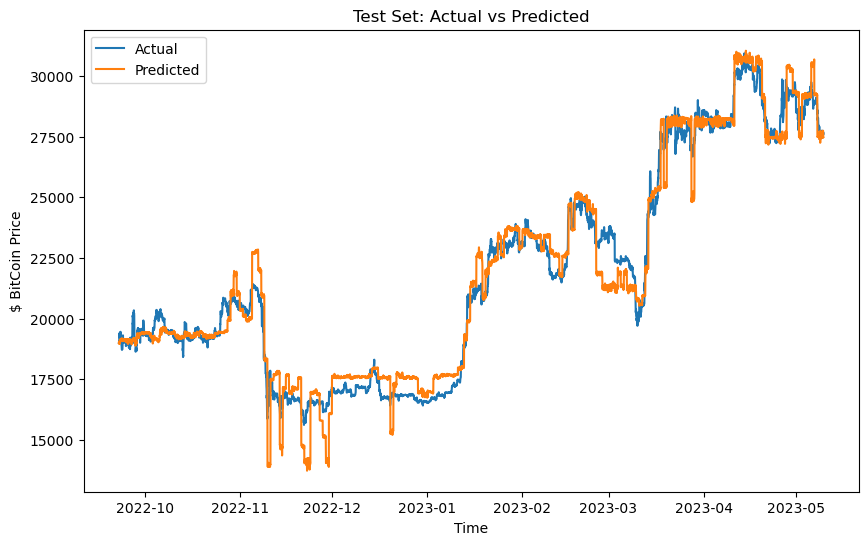

In [37]:
# Get the predicted values


# Plotting
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, ytest_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()


In [38]:
MAE_test,RMSE_test = calculate_metrics(y_test,ytest_pred)
print("The MAE for Test Set is: ",MAE_test,"\nThe RMSE for Test Set is: ",RMSE_test,"\nTest set R2: ", rf.score(X_test, y_test))

The MAE for Test Set is:  607.1016263761576 
The RMSE for Test Set is:  815.9513780851004 
Test set R2:  0.965650753724669


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


It looks OK but a little bit off from 2022-11 to 2022-12, let's see if there is a way to tune the model.

## Model Tuning

The random search process is too long, thus it is commented out. The hyperparameters are put directly into the models.

In [39]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
#     'learning_rate': [0.01, 0.05 ,0.1, 0.2, 0.3 ,0.5],
#     'max_depth': [3, 5, 7, 9],
#     'min_child_weight': [1, 2, 3, 4,5],
#     'gamma': [0.0, 0.05, 0.1,0.15, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0.0, 0.1, 0.2, 0.5],
#     'reg_lambda': [0.0, 0.1, 0.2, 0.5]
# }

# # Create an XGBoost regressor object
# xgb = XGBRegressor()

# # Split your data into training and testing sets

# # Perform random search
# random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
# random_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters:", rf_random_search.best_params_)
# print("Best Score:", rf_random_search.best_score_)
# final_xgb = rf_random_search.best_estimator_)

In [40]:
# rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,bootstrap=True,
#                            verbose=5,random_state=123)

# param_grid = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [3, 5, 7, None],
#     'min_samples_split': [2, 4, 6,8 , 10],
#     'min_samples_leaf': [1, 2, 3, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'bootstrap': [True, False]
# }

# # Create a Random Forest regressor object
# rf = RandomForestRegressor()



# # Perform random search
# rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
# rf_random_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters:", rf_random_search.best_params_)
# print("Best Score:", rf_random_search.best_score_)
# final_rf = random_search.best_estimator_

In [41]:
# It takes too long, I will comment them first
# grid_search.fit(X_train, y_train) 
# grid_search.best_params_ 
# # {'n_estimators': 500}

# XGB

In [48]:
from xgboost import XGBRegressor

In [49]:
xgb=XGBRegressor(subsample = 0.6, reg_lambda= 0.2, reg_alpha = 0.0, n_estimators = 800, min_child_weight= 3, max_depth = 9, learning_rate = 0.05, gamma = 0.05, colsample_bytree = 1.0)

In [50]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.05, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [51]:
ytest_pred2 = xgb.predict(X_test)

In [52]:
MAE_test,RMSE_test = calculate_metrics(y_test,ytest_pred2)
print("The MAE for Test Set is: ",MAE_test,"\nThe RMSE for Test Set is: ",RMSE_test,"\nTest set R2: ", xgb.score(X_test, y_test))

The MAE for Test Set is:  504.6673225207666 
The RMSE for Test Set is:  663.5857434759464 
Test set R2:  0.9772813382591758


# Neural net

In [53]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from scipy.stats import randint

code for hyper parameter tuning (commented out to save time):

In [ ]:

# # Define your MLPRegressor model
# mlp_reg = MLPRegressor(random_state=42)

# # Define the hyperparameter space
# param_dist = {
#     'hidden_layer_sizes': [50, 100, 150],  # Vary the hidden layer sizes
#     'activation': ['relu', 'tanh'],  # Vary the activation functions
#     'alpha': [0.0001, 0.001, 0.01],  # Vary the regularization parameter
# }

# # Create the RandomizedSearchCV object
# random_search = RandomizedSearchCV(mlp_reg, param_distributions=param_dist, n_iter=10, random_state=42)

# # Create the pipeline
# pipeline = make_pipeline(StandardScaler(), random_search)

# # Fit the pipeline (including hyperparameter tuning) to your training data
# pipeline.fit(X_train, y_train)

# # Get the best hyperparameters found by RandomizedSearchCV
# best_params = random_search.best_params_

# # Print the best hyperparameters
# print("Best Hyperparameters:", best_params)

# # Evaluate the pipeline on the test data
# score = pipeline.score(X_test, y_test)
# print("Test Score:", score)

In [62]:
mlp_reg = MLPRegressor(hidden_layer_sizes=[100, 100, 100], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)

In [63]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=[100, 100, 100],
                              random_state=42))])

In [65]:
ytest_pred3 = pipeline.predict(X_test)

In [66]:
MAE_test,RMSE_test = calculate_metrics(y_test,ytest_pred3)
print("The MAE for Test Set is: ",MAE_test,"\nThe RMSE for Test Set is: ",RMSE_test,"\nTest set R2: ", rf.score(X_test, y_test))

The MAE for Test Set is:  957.130161738607 
The RMSE for Test Set is:  1055.9259607862468 
Test set R2:  0.965650753724669


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


# Back test with the output of the 3 models

In [70]:
df = pd.DataFrame({'real_price':y_test,'rf_pred_price':ytest_pred,'xgb_pred_price':ytest_pred2,'mlp_pred_price':ytest_pred3})
df.set_index(pd.Index(range(len(df))),inplace=True)

In [71]:
df['average_predicted_price'] = df.iloc[:,1:].mean(axis=1)

In [72]:
for colname in df.columns[1:]:
    money = 50000
    coins = 2
    for i in range(len(df)-1):
        if df[colname][i+1] > df['real_price'][i]:
                coins += money/df['real_price'][i] 
                money = 0

        elif df[colname][i+1] < df['real_price'][i]:
                money += coins * df['real_price'][i]
                coins = 0
    final_asset_level = max(money, coins*df['real_price'][len(df)-1])
    initial_asset_level = 50000 + 2*df['real_price'][0]
    asset_growth = (final_asset_level - initial_asset_level) /  initial_asset_level
    print( 'The asset growth rate would be ' + str( round(asset_growth*100,2)) + '% if trades were conducted upon ' +str(colname) )

The asset growth rate would be 40.23% if trades were conducted upon rf_pred_price
The asset growth rate would be 39.11% if trades were conducted upon xgb_pred_price
The asset growth rate would be 104.91% if trades were conducted upon mlp_pred_price
The asset growth rate would be 67.89% if trades were conducted upon average_predicted_price


Neural network has a return rate of 104.91% in a 9 month simulation. It is very optimistic. Still validing the result by checking for leakage.